# ECON 570: Final Project

# Evaluation of Job Training Program with Nonexperimental Data

Masashi Yoshioka (3200-3439-52), Jincen Jiang (XXXX-XXXX-XX), Shuxian Mao (6221-2815-32)

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import basic functions
import numpy as np
import pandas as pd
import pyreadr
import random

# Import helper functions
from utils.functions import *

# Set random seeds
np.random.seed(570)
random.seed(570)

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

## 1. Introduction

### 1.1 Research Question

In this project, we will try to evaluate the job training program called the National Supported Work (NSW) Demonstration implemented around the United States in 1970s. In particular, we will examine whether we can replicate experimental estimates of average treatment effect (ATE) and/or average treatment effect on treated (ATET) by relying solely on  nonexperimental data.  

In short, our research question can be specified as: ***Could we obtain a reliable ATE and/or ATET estimates of the NSW by nonexperimental data?***

### 1.2 Literature Review

There has been a huge discussion about whether we can estimate a treatment effect using nonexperimental data. The answer still remains to be seen.  

The estimation of the causal effect of the NSW was first introduced by LaLonde (1986). He used data from randomized experiments conducted as a part of the NSW (the details will be explained in 2.1) and investigated the extent to which nonexperimental ATE estimates of the NSW can replicate experimental estimates. He first obtained the experimental ATE estimates from randomized experiments by, for example, taking a difference between averages of treatment and control groups, which would be an unbiased estimate for the ATE as long as the experiments were truly randomized. Then, he compared the results with the estimates from nonexperimental data (namely, CPS and PSID) obtained by several econometric methods. He failed to replicate the experimental estimates by nonexperimental data and concluded that the standard nonexperimental estimation methods are inaccurate relative to experimental benchmarks and sensitive to the modeling specifications.  

On the other hand, Dehejia and Wahba (1999, 2002) applied propensity score methods to the same dataset as LaLonde (1986) and concluded that they could successfully obtain the nonexprimental ATET estimates that were close to the experimental benchmarks. They claimed that although propensity score methods cannot account for important unobservables if any, it is still worth exploring the information contained in the observable covariates first, and propensity score matching methods can alleviate the bias due to systematic differences between treatment and control groups.

However, Smith and Todd (2005) pointed out that Dehejia and Wahba (1999, 2002) had excluded some samples from the original data of LaLonde (1986), which should have made it easier to estimate the ATET by nonexperimental data. They applied to the original LaLonde (1986) dataset the same propensity score matching method that Dehejia and Wahba (1999, 2002) had used, and discovered that the estimates were very sensitive to the choice of variables used in the propensity score estimation and the choice of samples of analysis. They concluded that the propensity score matching would not represent a general solution to causal inferences whereas it is potentially a useful tool.

### 1.3 Why Our Research Question Matters?

We will try to contribute to the above discussion by applying causal inference methods that we have learned in class. Our research question is extremely important from the empirical perspective because experimental data are rarely available in economics. We often need to use nonexperimental data to evaluate the effect of a certain program. Finding a causal relationship from nonexperimental data is one of the most important tasks of econometrics, but unfortunately, it might not provide a correct estimation of ATE/ATET if the arguments of LaLonde (1986) and Smith and Todd (2005) hold true in general.

### 1.4 Research Description

To answer our research question, we will use the dataset of LaLonde (1986) and try to estimate the ATE and/or the ATET of the NSW by applying a variety of methods. We will first apply regression (i.e., imputation) methods. Then, we will rely on different estimation methods that use propensity score, namely propensity score matching, Inverse Probability of Treatment Weighting (IPTW) and doubly robust estimators. In addition to the logistic regression that Dehejia and Wahba (1999, 2002) used to estimate the propensity score, we will also use Random Forest and Gradient Boosting in order to examine whether machine learning approaches can improve the estimation. We will use both the original data of LaLonde (1986) and its subset selected by Dehejia and Wahba (1999, 2002) to see if the criticism by Smith and Todd (2005) holds true.  

The rest of the notebook is organized as follows. Section 2 describes the data that we use along with the background of the NSW. Section 3 applies various models (regression, propensity score matching, IPTW estimator and doubly robust estimator) and obtains the ATE/ATET estimates. Section 4 compares the nonexperimental results with experimental benchmarks and analyzes what we have found. Section 5 concludes and suggests future work.

## 2. Data

### 2.1 The National Supported Work (NSW) Demonstration

We use a dataset from the NSW Demonstration, which has been commonly used in the causal inference literature, including LaLonde (1986), Dehejia and Wahba (1999, 2002) and Smith and Todd (2005) as explained above. 

The NSW was a job training program conducted in the mid-1970s at 15 sites around the U.S. Our dataset is focused on the program implemented in 10 sites from April 1975 to August 1977 among others. The program was targeted at 4 types of hard-to-employ people: female long-term AFDC<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) recipients, ex-drug addicts, ex-climinal offenders and high school dropouts. The potential participants had to satisfy a set of eligibility criteria that included: (i) they must have been currently unemployed, (ii) they must have spent no more than 3 months on one regular job of at least 20 hours per week during the preceding 6 months, and so forth. These criteria as well as self-selection made the participants in NSW essentially differ from the U.S. population in many characteristics.

The program operated as a randomized experiment by randomly assigning some applicants to a control group that was not allowed to participate in the program. For those assigned to the treatment group, the program guaranteed a job for 9 to 18 months, depending on the target group and site. The program paid the treatment group for their work, but the offered wage was lower than they would have received on a regular job. The participants were forced to find a regular job after their terms in the program expired.

The treatment and control groups were interviewed five times in total, one of which was a baseline and the others were follow-ups. Many people failed to complete these interviews and thus the sample attrition could have possibly caused biases. However, LaLonde (1986) suggests that the largest source of attrition, which was supposedly the interview schedule, should not have affected the integrity of the experimental design because the interviews were randomly scheduled. Here we just assume that LaLonde (1986) is right and will not deal with the potential sample attrition problem. The interviews provide information on demographic characteristics, employment history, household income and so forth.

We are interested in the effect of the NSW on earnings of participants. Since the program randomly assigned applicants to treatment and control groups, the experimental data would presumably give us an unbiased estimate for the average treatment effect (ATE) of the program. LaLonde (1986) compared the experimental data with nonexperimental data such as Current Population Survey (CPS) and Panel Study of Income Dynamics (PSID), concluding that nonexperimental data fail to generate similar results to experimental data. Dehejia and Wahba (1999, 2002) concentrated on subsamples whose earnings in 1974 are available, and concluded that propensity-score matching would generate the results close to experimental design. Thus, our dataset consists of 6 different groups of samples: experimental treatment group in LaLonde (1986), experimental control group in LaLonde (1986), experimental treatment subgroup in Dehejia and Wahba (1999, 2002), experimental control subgroup in Dehejia and Wahba (1999, 2002), nonexperimental data from CPS, and nonexperimental data from PSID. Using the dataset, we will see if nonexperimental data can generate estimates that are close enough to those given by experimental data.

### 2.2 Sampling Restrictions

The datasets were retrieved from https://github.com/jjchern/lalonde/tree/master/data on February 2, 2022. Note that it only includes the male samples due to the data availability of LaLonde (1986) whereas LaLonde (1986) analyzed the female samples as well. Dehejia and Wahba (1999, 2002) and Smith and Todd (2005) focused on males for the same reason. This repository also includes the subsamples of CPS and PSID that were chosen by LaLonde (1986) to make them resemble the NSW applicants to the extent possible. However, Dehejia and Wahba (1999, 2002) argued that choosing subsamples arbitrarily from the nonexperimental data would not improve the estimate. Smith and Todd (2005) also ignored these subsamples. Thus, we have decided to use the 6 groups described in 2.1 and discard subsamples of CPS and PSID. For the same reason, we do not do any sampling restrictions including outlier removal in order to avoid the potential bias from arbitrary selection of subsamples. Since the experiment was randomized, using all the samples would give an unbiased estimate of ATE. On the other hand, arbitrary sample restrictions can make treatment and control groups incomparable, which could cause a bias in the estimate.

### 2.3 Summary Statistics

First of all, we describe the summary statistics of each group below. The data includes the treatment status (`treat`), age (`age`), years of education (`education`), dummy for black (`black`), dummy for hispanic (`hispanic`), dummy for being married (`married`), dummy for high school dropout (`nodegree`), earnings in 1975 (`re75`) and in 1978 (`re78`). Note that the earnings in 1974 (`re74`) were only available with Dehejia and Wahba (1999, 2002) subsamples but not with LaLonde (1986) samples. Henceforth, the original experimental data of LaLonde (1986) and its subsamples selected by Dehejia and Wahba (1999, 2002) will be called "LaLonde dataset" and "DW subset", respectively, for the sake of brevity.

#### 2.3.1 LaLonde (1986) Experimental Data

First, we show the distributions of variables of LaLonde dataset. In particular, we compare the distributions of treated and controlled groups to see if they are truly comparable.

In [3]:
# Read LaLonde dataset
df_nsw = pyreadr.read_r('./data/nsw.rda')['nsw']
df_nsw.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78
0,Lalonde Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898
1,Lalonde Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043
2,Lalonde Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219
3,Lalonde Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996
4,Lalonde Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886


In [4]:
# Summarize the variables of treatment group of LaLonde dataset
print('Treatment Group of LaLonde Dataset')
df_nsw[df_nsw['treat'] == 1].describe().T

Treatment Group of LaLonde Dataset


,count,mean,std,min,25%,50%,75%,max
treat,297.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
age,297.0,24.626263,6.686391,17.0,20.000000,23.000000,27.000000,49.000000
education,297.0,10.380471,1.817712,4.0,9.000000,11.000000,12.000000,16.000000
black,297.0,0.801347,0.399660,0.0,1.000000,1.000000,1.000000,1.000000
hispanic,297.0,0.094276,0.292706,0.0,0.000000,0.000000,0.000000,1.000000
married,297.0,0.168350,0.374808,0.0,0.000000,0.000000,0.000000,1.000000
nodegree,297.0,0.730640,0.444376,0.0,0.000000,1.000000,1.000000,1.000000
re75,297.0,3066.098191,4874.888996,0.0,0.000000,1117.438965,4310.455078,37431.660156
re78,297.0,5976.352024,6923.796406,0.0,549.298401,4232.309082,9381.294922,60307.929688


In [5]:
# Summarize the variables of control group of LaLonde dataset
print('Control Group of LaLonde Dataset')
df_nsw[df_nsw['treat'] == 0].describe().T

Control Group of LaLonde Dataset


,count,mean,std,min,25%,50%,75%,max
treat,425.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
age,425.0,24.447059,6.590276,17.0,19.0,23.000000,28.000000,55.000000
education,425.0,10.188235,1.618686,3.0,9.0,10.000000,11.000000,14.000000
black,425.0,0.800000,0.400471,0.0,1.0,1.000000,1.000000,1.000000
hispanic,425.0,0.112941,0.316894,0.0,0.0,0.000000,0.000000,1.000000
married,425.0,0.157647,0.364839,0.0,0.0,0.000000,0.000000,1.000000
nodegree,425.0,0.814118,0.389470,0.0,1.0,1.000000,1.000000,1.000000
re75,425.0,3026.682756,5201.249820,0.0,0.0,823.254395,3649.769043,36941.269531
re78,425.0,5090.048301,5718.088763,0.0,0.0,3746.700928,8329.823242,39483.531250


The above tables describe the variables of treatment and control groups of LaLonde dataset. We can see that the characteristics of treatment and control groups are quite similar to each other except `re78`, which is an outcome of the program. Each pre-treatment variable has a similar mean, standard deviation and so forth. If the experiments were truly randomized, treatment and control groups should be comparable in every pre-treatment variable. The above statistics are consistent with the randomized design of the NSW.

#### 2.3.2 Dehejia and Wahba (1999, 2002) Experimental Data

Then, we compare treatment and control groups of DW subset.

In [6]:
# Read DW subset
df_nsw_dw = pyreadr.read_r('./data/nsw_dw.rda')['nsw_dw']
df_nsw_dw.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,Dehejia-Wahba Sample,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,0.0,9930.045898
1,Dehejia-Wahba Sample,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,0.0,3595.894043
2,Dehejia-Wahba Sample,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,24909.449219
3,Dehejia-Wahba Sample,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,0.0,7506.145996
4,Dehejia-Wahba Sample,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,0.0,289.789886


In [7]:
# Summarize the variables of treatment group of DW subset
print('Treatment Group of DW subset')
df_nsw_dw[df_nsw_dw['treat'] == 1].describe().T

Treatment Group of DW subset


,count,mean,std,min,25%,50%,75%,max
treat,185.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000
age,185.0,25.816216,7.155019,17.0,20.000000,25.000000,29.000000,48.000000
education,185.0,10.345946,2.010650,4.0,9.000000,11.000000,12.000000,16.000000
black,185.0,0.843243,0.364558,0.0,1.000000,1.000000,1.000000,1.000000
hispanic,185.0,0.059459,0.237124,0.0,0.000000,0.000000,0.000000,1.000000
married,185.0,0.189189,0.392722,0.0,0.000000,0.000000,0.000000,1.000000
nodegree,185.0,0.708108,0.455867,0.0,0.000000,1.000000,1.000000,1.000000
re74,185.0,2095.573693,4886.620354,0.0,0.000000,0.000000,1291.468018,35040.070312
re75,185.0,1532.055313,3219.250879,0.0,0.000000,0.000000,1817.284058,25142.240234
re78,185.0,6349.143502,7867.402183,0.0,485.229797,4232.309082,9642.999023,60307.929688


In [8]:
# Summarize the variables of control group of DW subset
print('Control Group of DW subset')
df_nsw_dw[df_nsw_dw['treat'] == 0].describe().T

Control Group of DW subset


,count,mean,std,min,25%,50%,75%,max
treat,260.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
age,260.0,25.053846,7.057745,17.0,19.0,24.000000,28.000000,55.000000
education,260.0,10.088462,1.614325,3.0,9.0,10.000000,11.000000,14.000000
black,260.0,0.826923,0.379043,0.0,1.0,1.000000,1.000000,1.000000
hispanic,260.0,0.107692,0.310589,0.0,0.0,0.000000,0.000000,1.000000
married,260.0,0.153846,0.361497,0.0,0.0,0.000000,0.000000,1.000000
nodegree,260.0,0.834615,0.372244,0.0,1.0,1.000000,1.000000,1.000000
re74,260.0,2107.026651,5687.905639,0.0,0.0,0.000000,139.424698,39570.679688
re75,260.0,1266.909015,3102.982088,0.0,0.0,0.000000,650.096451,23031.980469
re78,260.0,4554.801120,5483.836001,0.0,0.0,3138.795532,7288.420044,39483.531250


Compared to LaLonde dataset, some of the variables appear to show different distributions between treatment and control groups in DW subsets. For instance, earnings in 1975 (`re75`) of treatment group are higher than those of control group, although the difference does not appear to be statistically significant. By choosing only the subsamples whose earnings in 1974 were available, Dehejia and Wahba (1999, 2002) might have distorted the samples and hurt the comparability between treatment and control groups as argued by Smith and Todd (2005).

#### 2.3.3 Nonexperimental Data (CPS and PSID)

Now we will see how differently distributed are the variables of two nonexperimental data, CPS and PSID, from experimental data of LaLonde and DW.

In [9]:
# Read CPS data
df_cps = pyreadr.read_r('./data/cps_controls.rda')['cps_controls']
df_cps.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,CPS1,0.0,45.0,11.0,0.0,0.0,1.0,1.0,21516.669922,25243.550781,25564.669922
1,CPS1,0.0,21.0,14.0,0.0,0.0,0.0,0.0,3175.970947,5852.564941,13496.080078
2,CPS1,0.0,38.0,12.0,0.0,0.0,1.0,0.0,23039.019531,25130.759766,25564.669922
3,CPS1,0.0,48.0,6.0,0.0,0.0,1.0,1.0,24994.369141,25243.550781,25564.669922
4,CPS1,0.0,18.0,8.0,0.0,0.0,1.0,1.0,1669.295044,10727.610352,9860.869141


In [10]:
# Summarize the variables of CPS
print('CPS')
df_cps.describe().T

CPS


,count,mean,std,min,25%,50%,75%,max
treat,15992.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
age,15992.0,33.225238,11.045216,16.0,24.000000,31.000000,42.000000,55.000000
education,15992.0,12.027514,2.870846,0.0,11.000000,12.000000,13.000000,18.000000
black,15992.0,0.073537,0.261024,0.0,0.000000,0.000000,0.000000,1.000000
hispanic,15992.0,0.072036,0.258556,0.0,0.000000,0.000000,0.000000,1.000000
married,15992.0,0.711731,0.452971,0.0,0.000000,1.000000,1.000000,1.000000
nodegree,15992.0,0.295835,0.456432,0.0,0.000000,0.000000,1.000000,1.000000
re74,15992.0,14016.800360,9569.795964,0.0,4403.452393,15123.580078,23584.179688,25862.320312
re75,15992.0,13650.803522,9270.403408,0.0,4398.823242,14557.110352,22923.736816,25243.550781
re78,15992.0,14846.659650,9647.391501,0.0,5669.298096,16421.974609,25564.669922,25564.669922


In [11]:
# Read PSID data
df_psid = pyreadr.read_r('./data/psid_controls.rda')['psid_controls']
df_psid.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re74,re75,re78
0,PSID,0.0,47.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,PSID,0.0,50.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,PSID,0.0,44.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,PSID,0.0,28.0,12.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,PSID,0.0,54.0,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [12]:
# Summarize the variables of PSID
print('PSID')
df_psid.describe().T

PSID


,count,mean,std,min,25%,50%,75%,max
treat,2490.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
age,2490.0,34.850602,10.440757,18.0,26.000000,33.000000,44.000000,55.000000
education,2490.0,12.116867,3.082435,0.0,11.000000,12.000000,14.000000,17.000000
black,2490.0,0.250602,0.433447,0.0,0.000000,0.000000,1.000000,1.000000
hispanic,2490.0,0.032530,0.177439,0.0,0.000000,0.000000,0.000000,1.000000
married,2490.0,0.866265,0.340436,0.0,1.000000,1.000000,1.000000,1.000000
nodegree,2490.0,0.305221,0.460593,0.0,0.000000,0.000000,1.000000,1.000000
re74,2490.0,19428.745805,13406.877171,0.0,10775.966797,18417.107422,26450.101562,137148.687500
re75,2490.0,19063.337668,13596.954865,0.0,9846.774414,17903.226562,26496.773438,156653.234375
re78,2490.0,21553.920924,15555.345539,0.0,11526.266602,20688.171875,29554.531250,121173.578125


The above statistics obviously show that neither CPS nor PSID samples are comparable with LaLonde dataset or DW subset. For instance, samples in CPS and PSID are 33 and 35 years old on average, respecively, whereas the average age of LaLonde dataset and DW subset are 25-26 regardless of treatment and control groups. We will show the differences graphically below.  

Before that, we append all the datasets for convenience.

In [13]:
# Combine all of the datasets
df_nsw.loc[df_nsw['treat'] == 1, 'data_id'] = 'LT'
df_nsw.loc[df_nsw['treat'] == 0, 'data_id'] = 'LC'
df_nsw_dw.loc[df_nsw_dw['treat'] == 1, 'data_id'] = 'DWT'
df_nsw_dw.loc[df_nsw_dw['treat'] == 0, 'data_id'] = 'DWC'
df_cps.data_id = 'CPS'

df = pd.concat([df_nsw, df_nsw_dw, df_cps, df_psid]).reset_index(drop = True)
df.data_id = pd.Categorical(df.data_id, ['LT', 'LC', 'DWT', 'DWC', 'CPS', 'PSID'])
df.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,re74
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,NaN
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,NaN
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,NaN
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996,NaN
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,NaN


The column `data_id` represents the 6 groups that we have defined, i.e., LaLonde experimental treatment (`'LT'`), LaLonde experimental control (`'LC'`), DW experimental treatment (`'DWT'`), DW experimental control (`'DWC'`), CPS nonexperimental control (`'CPS'`) and PSID nonexperimental control (`'PSID'`).  
  
We do not transform the data except in linear regression models, where we will use the squared values of `age` as one of the covariates following LaLonde (1986). Even if we do not transform our data manually, Random Forest and Gradient Boosting will be able to fit to non-linear relationships.  
  
We define a varaible `dif` which represents the difference between earnings in 1978 and 1975, i.e., `re78` minus `re75`. We will use both `dif` and `re78` as our dependent variables.

In [14]:
# Add a difference in earnings between 1978 and 1975
df['dif'] = df['re78'] - df['re75']
df

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,re74,dif
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.000000,9930.045898,NaN,9930.045898
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.000000,3595.894043,NaN,3595.894043
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.000000,24909.449219,NaN,24909.449219
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.000000,7506.145996,NaN,7506.145996
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.000000,289.789886,NaN,289.789886
...,...,...,...,...,...,...,...,...,...,...,...,...
19644,PSID,0.0,47.0,8.0,0.0,0.0,1.0,1.0,33837.097656,38568.664062,44667.363281,4731.566406
19645,PSID,0.0,32.0,8.0,0.0,0.0,1.0,1.0,67137.093750,59109.062500,47022.402344,-8028.031250
19646,PSID,0.0,47.0,10.0,0.0,0.0,1.0,1.0,47968.113281,55710.292969,48197.964844,7742.179688
19647,PSID,0.0,54.0,0.0,0.0,1.0,1.0,1.0,44220.968750,20540.398438,49228.539062,-23680.570312


#### 2.3.4 Comparisons between Experimental and Nonexperimental Data

To make clearer the differences between experimental and nonexperimental data, we show various group-by statistics below.

##### Average by Group

In [15]:
# Show averages by group
df.groupby('data_id').mean().T

data_id,LT,LC,DWT,DWC,CPS,PSID
treat,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
age,24.626263,24.447059,25.816216,25.053846,33.225238,34.850602
education,10.380471,10.188235,10.345946,10.088462,12.027514,12.116867
black,0.801347,0.800000,0.843243,0.826923,0.073537,0.250602
hispanic,0.094276,0.112941,0.059459,0.107692,0.072036,0.032530
married,0.168350,0.157647,0.189189,0.153846,0.711731,0.866265
nodegree,0.730640,0.814118,0.708108,0.834615,0.295835,0.305221
re75,3066.098191,3026.682756,1532.055313,1266.909015,13650.803522,19063.337668
re78,5976.352024,5090.048301,6349.143502,4554.801120,14846.659650,21553.920924
re74,NaN,NaN,2095.573693,2107.026651,14016.800360,19428.745805


The above table shows the averages of the characteristics by group. We can see that the experimental data are totally different from CPS and PSID.  

As we have already seen above, the average age is much lower in the experimental data than in CPS/PSID. In addition, compared to CPS/PSID, the experimental samples have the lower average year of education, much more black people, more hispanic people, more singles and more dropouts. These differences are not surprising considering the eligibility criteria for the NSW. Moreover, the average earnings of the NSW samples are much lower than those of CPS/PSID. Therefore, it is obvious that taking differences between experimental treatment group and *nonexperimental* control group would not provide a good estimate of the causal effect of the program because they are totally incomparable.

##### Boxplot by Group

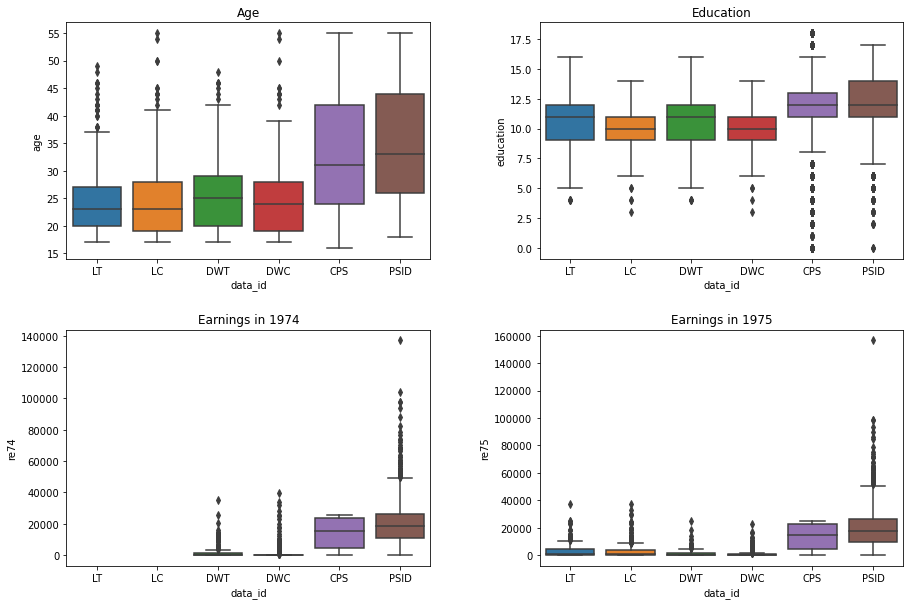

In [16]:
# Show boxplots
fn_boxplots(df = df)

The above boxplots show the distributions of pre-treatment continuous variables by group. Again, it is obvious that the experimental data are totally different from CPS/PSID in all the characteristics. In order to estimate the ATE and/or the ATET from the nonexperimental data, we should take these differences into consideration.

## 3. Modeling

In this section, we will apply the following 4 estimation methods: regression, propensity score matching, IPTW estimator and doubly robust estimator.  
  
As a notation, we will let $D$ denote the treatment variable (`treat`), $X$ denote the covariates and $Y$ denote the outcome henceforth. Since `re74` is not available for LaLonde dataset, we define $X$ by the other pre-treatment variables, i.e., `age`, `education`, `black`, `hispanic`, `married`, `nodegree` and `re75`. We assume two kinds of outcomes, difference in earnings between 1975 and 1978 (`dif`) and earnings in 1978 (`re78`), as $Y$. If the experiment is randomized, the choice of $Y$ would not affect the ATE/ATET estimates because the pre-treatment variable `re75` should be comparable between treatment and control groups under randomized selection. On the other hand, it could affect the estimates when we rely on nonexperimental data. Thus, we assume both outcomes to make our research comprehensive.

### 3.1 Regression

Before applying each model, let us provide some theoretical background that is essential for our estimation.

Under the assumption of unconfoundedness $Y_0, Y_1 \perp D | X$ where $Y_0$ and $Y_1$ are potential outcomes when treated and controlled, respectively, we can obtain the ATE and ATET as

$$
\begin{align*}
ATE &\equiv E[Y_1 - Y_0] \\
    &= E_X[E[Y_1 - Y_0 | X]] \\
    &= E_X[E[Y_1|X] - E[Y_0 | X]] \\
    &= E_X[E[Y_1|X, D=1] - E[Y_0 | X, D=0]] \\
    &= E_X[E[Y|X, D=1] - E[Y|X, D=0]] \\
    &\equiv E_X[\mu_1 (X) - \mu_0 (X)], \\
ATET &\equiv E[Y_1 - Y_0 | D = 1] \\
     &= E[Y_1 | D = 1] - E[Y_0 | D = 1] \\
     &= E[Y| D = 1] - E_{X|D = 1}[E[Y_0 | X, D = 1]| D = 1] \\
     &= E[Y| D = 1] - E_{X|D = 1}[E[Y_0 | X, D = 0]| D = 1] \\
     &= E[Y| D = 1] - E_{X|D = 1}[E[Y | X, D = 0]| D = 1] \\
     &= E[Y| D = 1] - E_{X|D = 1}[\mu_0 (X)| D = 1]
\end{align*}
$$

respectively, where $\mu_1 (X) \equiv E[Y | D = 1, X]$ and $\mu_0 (X) \equiv E[Y | D = 0, X]$ are conditional means of $Y$.

In this section, we try to estimate $\mu_1 (X)$ and $\mu_0$ using different regression models: i) linear regression, ii) Random Forest regression and iii) Gradient Boosting regression. Using the estimates $\hat{\mu}_1 (X)$ and $\hat{\mu}_0 (X)$ from each model, we can estimate the ATE and ATET by

$$
\begin{align*}
\hat{\tau}_{ATE} &= \frac{1}{n} \sum_{i = 1}^n \left( \hat{\mu}_1 (X_i) - \hat{\mu}_0 (X_i) \right),\\
\hat{\tau}_{ATET} &= \frac{1}{n_1} \sum_{i|D_i = 1} \left( Y_i - \hat{\mu}_0 (X_i) \right),
\end{align*}
$$

respectively, where $n$ is a sample size and $n_1 \equiv \sum_{i = 1}^n D_i$ is the number of treated samples.  
  
If $\hat{\mu}_1 (X)$ and $\hat{\mu}_0 (X)$ are valid estimators, it should hold that

$$
\sum_{i|D_i = 1} \hat{\mu}_1 (X_i) =  \sum_{i|D_i = 1} Y_i, \sum_{i|D_i = 0} \hat{\mu}_0 (X_i) =\sum_{i|D_i = 0} Y_i.
$$

This condition can be easily understood considering the regression with the intercept. Thus, it can be shown that

$$
\begin{align*}
\hat{\tau}_{ATE} &= \frac{1}{n} \left[ \sum_{i|D_i = 1} \left( Y_i - \hat{\mu}_0 (X_i) \right) + \sum_{i|D_i = 0} \left( \hat{\mu}_1 (X_i) - Y_i \right) \right].\\
\end{align*}
$$

This explains why the above estimators are called regression imputation estimators (e.g., Abadie & Cattaneo, 2018). These estimators essentially try to impute the unobserved potential outcomes by regression.

#### 3.1.1 Linear Regression

We first apply linear regression models to obtain the ATE/ATET estimates. In the linear regression model, we simply assume

$$
E[Y|D, X] = \alpha + \tau D + X \beta,
$$

which implies $E[Y|D = 1, X] - E[Y|D = 0, X] = \tau$. Thus, in this specification, both ATE and ATET will be identical to $\tau$.  
  
We run OLS to obtain the estimate for $\tau$. When experimental data are used, the OLS estimator for $\tau$ would be unbiased regardless of the choice of the covariates whereas including covariates can help reduce the standard error of the estimate. Since all the covariates are pre-treatment variables, we do not have to worry about selection biases.  
  
For comparison, we specify three sets of covariates: i) no covariates, ii) age and squared age, and iii) age, squared age and all the other covariates. We use squared age following LaLonde (1986). 

First, we assume the difference in earnings between 1975 and 1978 (`dif`) as outcome $Y$. As a benchmark, we obtain the estimates from experimental data.

In [17]:
# Obtain benchmark experimental ATE/ATET estimates over LaLonde dataset
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'LC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: LaLonde


,Without control,With age,With all controls
treat,846.8883,856.9110,800.5353*
,(560.1417),(557.6783),(468.1002)
age,,-703.6823***,-140.3273
,,(241.6312),(214.1023)
age2,,11.5827***,2.6795
,,(4.0793),(3.5850)
black,,,-1441.5833*
,,,(801.7171)
education,,,195.0935
,,,(181.5737)


As we have explained above, the coefficient on `treat` would be the estimate for the ATE/ATET. We can see that it is quite stable across different specifications and around 800&ndash;900 when we use LaLonde dataset. Assuming that the experiments were truly randomized, which appears to be a reasonable assumption considering the comparable distributions shown in Section 2, we can use these results as a benchmark for the ATE/ATET estimates of LaLonde dataset. Simply said, our goal is to obtain nonexperimental ATE/ATET estimates that are close to 800&ndash;900 for LaLonde dataset.

Now we run OLS over DW subset with the same modeling specifications.

In [18]:
# Obtain benchmark experimental ATE/ATET estimates over DW subset
fn_regression_result(outcome = 'dif', treat_id = 'DWT', control_id = 'DWC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: Dehejia and Wahba
Control: Dehejia and Wahba


,Without control,With age,With all controls
treat,1529.1961**,1516.9969**,1636.1083**
,(679.5380),(682.2371),(638.3005)
age,,-46.6970,146.4019
,,(279.9331),(274.4144)
age2,,1.1926,-1.5624
,,(4.6231),(4.4943)
black,,,-2121.4107*
,,,(1169.9945)
education,,,369.3361
,,,(229.6550)


Notably, the ATE/ATET estimates of DW subset is much larger than those of LaLonde dataset. It is about 1,500&ndash;1,600, which would be the benchmark for DW subset.

Now we will try to replicate these results using nonexperimental data. To do so, we replace experimental control group by nonexperimental data (CPS or PSID) and apply the same methods.  

First, we create the data that consists of treatment group of LaLonde dataset (`'LT'`) and CPS or PSID. If the unconfoundedness holds and our modeling specification $E[Y|D, X] = \alpha + \tau D + X \beta$ is correct, we should be able to get similar results even when using CPS or PSID as the control group. The following tables show the regression results.

In [19]:
# Obtain nonexperimental ATE/ATET estimates over LaLonde treatment and CPS
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'CPS', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: CPS


,Without control,With age,With all controls
treat,1714.3977***,195.1746,-999.6094**
,(452.2939),(441.8344),(451.8801)
age,,-561.3006***,-60.2642
,,(36.6097),(41.1105)
age2,,5.7530***,-0.2232
,,(0.5158),(0.5624)
black,,,-855.1777***
,,,(215.0451)
education,,,139.2424***
,,,(29.0907)


In [20]:
# Obtain nonexperimental ATE/ATET estimates over LaLonde treatment and PSID
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'PSID', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: PSID


,Without control,With age,With all controls
treat,419.6706,-749.2072,-1347.7964*
,(650.5836),(691.9516),(804.4751)
age,,25.8463,183.2980
,,(154.1027),(153.2805)
age2,,-2.1310,-3.2828
,,(2.1075),(2.0895)
black,,,-582.3745
,,,(491.1658)
education,,,657.1983***
,,,(103.2634)


Compared to the experimental estimates, the nonexperimental estimates vary significantly depending on the modeling specification and selection of controlled samples. It ranges from negative to positive values, and even worse, some of the results are highly statistically significant, which is misleading for researchers&mdash;this observation means that they can easily overstate or understate the causal effect of the NSW. Unfortunately, none of them could generate a similar estimate to the benchmark. It seems that controlling for $X$ would not lead us to a correct estimate of ATE/ATET, which is the main implication of LaLonde (1986).

We apply the same linear regression methods to DW subset as well. To save the space, we do not show all the regression results but only the estimated coefficients $\hat{\tau}$ for each sample. The following table summarizes all the results.

In [21]:
# Summarize the linear regression results
reg_summary_dif = fn_regression_summary(df = df, outcome = 'dif')
reg_summary_dif

,Outcome,Treatment,Control,Without control,With age,With all controls
0,dif,LT,LC,846.888287,856.910955,800.535314
1,dif,LT,CPS,1714.397705,195.174602,-999.609429
2,dif,LT,PSID,419.670577,-749.207210,-1347.796366
3,dif,DWT,DWC,1529.196083,1516.996931,1636.108327
4,dif,DWT,CPS,3621.232061,2383.311533,622.547024
5,dif,DWT,PSID,2326.504934,1256.927930,455.570948


The table presents that we fail to replicate experimental estimates by linear regression models over DW subset as well. The nonexperimental ATE/ATET estimates differ to a significant extent depending on modeling specifications and choice of controlled samples. None of the nonexperimental estimates are close to the benchmark, which is around 1,500&ndash;1,600.  
  
We also assume the earnings in 1978 (`re78`) as outcome below. The following table presents the results of $\hat{\tau}$ when `re78` is used as outcome rather than `dif`.

In [22]:
# Summarize the linear regression results for earnings in 1978
reg_summary_re78 = fn_regression_summary(df = df, outcome = 're78')
reg_summary_re78

,Outcome,Treatment,Control,Without control,With age,With all controls
0,re78,LT,LC,886.303722,881.739626,800.535314
1,re78,LT,CPS,-8870.307627,-7172.308044,-999.609429
2,re78,LT,PSID,-15577.568900,-13267.657059,-1347.796366
3,re78,DWT,DWC,1794.342382,1736.057724,1636.108327
4,re78,DWT,CPS,-8497.516148,-7274.306837,622.547024
5,re78,DWT,PSID,-15204.777421,-13268.950367,455.570948


The table implies that when using experimental data, we could get similar estimates to those from `dif` by using `re78` as the dependent variable. By design, we get exactly the same results in the column of "With all controls" as in the case of `dif` because our covariates include `re75` and `dif` is defined by `re78` minus `re75`. Again, the nonexperimental estimates fail to generate the estimates that are close to the benchmark.  
  
Here, we conclude that the linear regression fails to replicate experimental results by nonexperimental data. That is possibly because (i) unconfoundedness fails to hold or (ii) the specification of the linear model is wrong. We will apply other regression methods to see if (ii) is true. Note that the assumption of unconfoundedness is not testable.

In [23]:
# Output the results as .csv file
df_lr = pd.concat([reg_summary_dif, reg_summary_re78], axis = 0)
df_lr.to_csv('./results/lr.csv', index = False)

#### 3.1.2 Random Forest Regression

Now we will estimate $\mu_d (X = x) = f(d, x)$ using a machine learning approach.  

First, we fit $Y = f(D, X)$ by Random Forest and get the estimator $\hat{f}(D, X)$. Then, the ATE and ATET estimates are given by the following sample averages:

$$
\begin{align*}
\hat{\tau}_{ATE} &= \frac{1}{n} \left[ \sum_{i|D_i = 1} \left( Y_i - \hat{f}(D_i = 0, X_i) \right) + \sum_{i|D_i = 0} \left( \hat{f}(D_i = 1, X_i) - Y_i \right) \right],\\
\hat{\tau}_{ATET} &= \frac{1}{n_1} \sum_{i|D_i = 1} \left( Y_i - \hat{f}(D_i = 0, X_i) \right).
\end{align*}
$$

Random Forest often performs well for prediction, and it is among the most widely used machine learning methods currently (Müller & Guido, 2016). The Random Forest can predict a non-linear relationship between dependent and independent variables, so we expect that it can potentially give us nonexperimental estimates that are closer to experimental ones than linear regressions.  

We tune two hyperparameters for Random Forest, the number of trees in the forest (`n_estimators`) and the number of features considered for splitting (`max_features`) henceforth, to avoid overfitting and underfitting. The hyperparameter tuning is implemented by 5-fold cross validation.

The following table shows our estimates for ATE and ATET.

In [24]:
# ATE/ATET estimates using Random Forest regression
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

RF_summary = fn_ML_results(df = df, method = 'RF', param_grid = param_grid)
RF_summary[RF_summary.Outcome == 'dif'].reset_index(drop = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [39:16<00:00, 1178.15s/it]


,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,dif,LT,LC,Regression,RF,913.562291,730.663394
1,dif,LT,CPS,Regression,RF,-3919.466121,-202.885791
2,dif,LT,PSID,Regression,RF,-2514.203037,-1276.980889
3,dif,DWT,DWC,Regression,RF,1395.593161,1386.034357
4,dif,DWT,CPS,Regression,RF,-969.110691,1214.246394
5,dif,DWT,PSID,Regression,RF,147.656866,-303.618709


Unfortunately, we fail to replicate experimental benchmarks by applying Random Forest regressions on nonexperimental data. The results from experimental data (i.e., `'LC'` and `'DWC'` as controls) are somewhat similar to those from linear regressions, but nonexperimental estimates could not replicate the benchmarks for either ATE or ATET. The ATET estimate for DW subset with CPS control gives us a similar estimate to benchmark (1,214), but it can be just a coincidence. The estimates vary significantly according to the choice of control groups.  

The following table shows the results when we use earnings in 1978 (`re78`) as outcome.

In [25]:
RF_summary[RF_summary.Outcome == 're78'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,re78,LT,LC,Regression,RF,851.942763,751.353774
1,re78,LT,CPS,Regression,RF,-2642.431374,-315.532116
2,re78,LT,PSID,Regression,RF,-6061.104723,-1613.389493
3,re78,DWT,DWC,Regression,RF,1465.645909,1530.928505
4,re78,DWT,CPS,Regression,RF,-683.568348,1160.648657
5,re78,DWT,PSID,Regression,RF,-1472.083114,-789.357286


The implications are basically the same. The ATET estimate for DW subset with CPS control gives us relatively a good estimate, but it can be just a coincidence, and estimates are very sensitive to the choice of control group.

#### 3.1.3 Gradient Boosting Regression

Now we fit $Y = f(D, X)$ by Gradient Boosting. Gradient Boosting is another ensemble method that combines multiple decision trees. It frequently becomes a winner in machine learning competitions (Müller & Guido, 2016). We expect that it can provide different nonlinear estimations of $Y = f(D, X)$ than Random Forest and make our analysis robust and comprehensive. As in 3.1.2, the ATE and ATET estimates are given by

$$
\begin{align*}
\hat{\tau}_{ATE} &= \frac{1}{n} \left[ \sum_{i|D_i = 1} \left( Y_i - \hat{f}(D_i = 0, X_i) \right) + \sum_{i|D_i = 0} \left( \hat{f}(D_i = 1, X_i) - Y_i \right) \right],\\
\hat{\tau}_{ATET} &= \frac{1}{n_1} \sum_{i|D_i = 1} \left( Y_i - \hat{f}(D_i = 0, X_i) \right).
\end{align*}
$$

We consider exactly the same hyperparameters, `n_estimators` and `max_features`, for Gradient Boosting as well. The advantage of Gradient Boosting is that it is fairly robust to overfitting and generally less time-consuming than Random Forest. While we tuned over the same hyperparameter candidates, the runtime turned out to be much shorter than in 3.1.2. Again, the hyperparameters are tuned by 5-fold cross validation.  

The following table shows the estimates when we use `dif` as the dependent variable.

In [26]:
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

GB_summary = fn_ML_results(df = df, method = 'GB', param_grid = param_grid)
GB_summary[GB_summary.Outcome == 'dif'].reset_index(drop = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [08:57<00:00, 268.76s/it]


,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,dif,LT,LC,Regression,GB,715.291790,763.023051
1,dif,LT,CPS,Regression,GB,-4763.138893,-599.751690
2,dif,LT,PSID,Regression,GB,-2416.219321,-1152.807313
3,dif,DWT,DWC,Regression,GB,1394.664391,1423.638152
4,dif,DWT,CPS,Regression,GB,-2380.891771,1037.101413
5,dif,DWT,PSID,Regression,GB,-666.331403,611.295655


Just like Random Forest, Gradient Boosting fails to replicate experimental estimates by nonexperimental data. The ATET estimate for DW subset with CPS control is relatively good again, but we should not consider it as improvement. Actually, as the following table presents, the estimate will be far from the benchmark when we use `re78` as outcome.

In [27]:
GB_summary[GB_summary.Outcome == 're78'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,re78,LT,LC,Regression,GB,751.913736,782.370136
1,re78,LT,CPS,Regression,GB,-3832.432449,-1017.893113
2,re78,LT,PSID,Regression,GB,-5362.091815,-1995.153173
3,re78,DWT,DWC,Regression,GB,1471.936854,1583.223852
4,re78,DWT,CPS,Regression,GB,-1992.434869,466.529405
5,re78,DWT,PSID,Regression,GB,-5033.660677,-1152.669740


Unfortunately, Gradient Boosting has not improved our nonexperimental estimations.

In [28]:
# Output the results as .csv file
df_MLreg = pd.concat([RF_summary, GB_summary], axis = 0)
df_MLreg.to_csv('./results/MLreg.csv', index = False)

#### 3.1.4 Summary &ndash; Regression

Overall, regression methods fail to replicate experimental estimates of ATE and ATET using nonexperimental data. The results have not been improved by machine learning methods. This implies the possibility that the assumption of unconfoundedness might not hold with our data&mdash;there might be an important unobservable variable.

In the following subsections, we will see if propensity score estimation can improve the situation.

### 3.2 Propensity Score Matching

In this subsection, we will apply the propensity score matching method following Dehejia and Wahba (1999, 2002). First, we will provide some technical background. 
  
The propensity score is defined by $p(X) \equiv \mathrm{Pr}(D = 1 | X)$. Suppose the assumption of unconfoundedness $Y_0, Y_1 \perp D | X$ holds again. Then, the law of iterated expectations implies that

$$
\begin{align*}
\mathrm{Pr}(D = 1 | p(X))  &= E_{X|p(X)}[\mathrm{Pr}(D = 1 | X, p(X))|p(X)] \\
                           &= E_{X|p(X)}[\mathrm{Pr}(D = 1 | X)|p(X)] \\
                           &\equiv E_{X|p(X)}[p(X)|p(X)] \\
                           &= p(X) \\
                           &\equiv \mathrm{Pr}(D = 1 | X).
\end{align*}
$$

Thus,

$$
\begin{align*}
\mathrm{Pr}(D = 1|Y_0, Y_1, p(X)) &= E_{X|Y_0, Y_1, p(X)}[\mathrm{Pr}(D = 1|Y_0, Y_1, p(X), X)|Y_0, Y_1, p(X)] \\
                                  &= E_{X|Y_0, Y_1, p(X)}[\mathrm{Pr}(D = 1|Y_0, Y_1, X)|Y_0, Y_1, p(X)] \\
                                  &= E_{X|Y_0, Y_1, p(X)}[\mathrm{Pr}(D = 1|X)|Y_0, Y_1, p(X)] \\
                                  &\equiv E_{X|Y_0, Y_1, p(X)}[p(X)|Y_0, Y_1, p(X)] \\
                                  &= p(X) \\
                                  &\equiv \mathrm{Pr}(D = 1 | X) \\
                                  &= \mathrm{Pr}(D = 1 | p(X)),
\end{align*}
$$

which implies $Y_0, Y_1 \perp D | p(X)$.  

Therefore, replacing $X$ by $p(X)$ in 3.1, we can obtain ATE and ATET as

$$
\begin{align*}
ATE  &= E_{p(X)}[E[Y|p(X), D = 1] - E[Y|p(X), D = 0]],\\
ATET &= E[Y| D = 1] - E_{p(X)|D = 1}[E[Y | p(X), D = 0]| D = 1].
\end{align*}
$$

This motivates us to match samples based on propensity score. The propensity score substantially reduces the dimensionality of covatiates $X$. In other words, it is much easier to control for $p(X)$ than $X$. Comparing the samples that have similar propensity scores, we can virtually control for $p(X)$ and estimate the ATE and ATET.  

Let us start with ATET. The first term of ATET, $E[Y| D = 1]$, can be estimated by average of treated outcome, so what we should do is to estimate the second term $E_{p(X)|D = 1}[E[Y | p(X), D = 0]| D = 1]$. The propensity score matching method enables us to estimate it by the following steps:
1. Estimate $p(X)$ by $\hat{p}(X)$.
2. Compute $\mathrm{logit}(X_i) \equiv \ln (\frac{\hat{p}(X_i)}{1 - \hat{p}(X_i)})$ for all the samples $i = 1, \ldots, n$.
3. For each sample $i$ such that $D_i = 1$ (i.e., treated sample), we match a set of samples $J_i$ from control group (i.e., $D_j = 0$ for $j \in J_i$) so that $\mathrm{logit}(X_j)$ is sufficiently close to $\mathrm{logit}(X_i)$ for $j \in J_i$. $J_i$ can include multiple samples. We define maximum number of matched samples $|J_i|$ and/or maximum difference in $|\mathrm{logit}(X_i) - \mathrm{logit}(X_j)|$ (caliper) to identify matched samples.
4. Then, the ATET is estimated by

$$
\hat{\tau}_{ATET} = \frac{1}{n_1} \sum_{i|D_i = 1} \left( Y_i - \frac{1}{|J_i|} \sum_{j \in J_i} Y_j \right).
$$

Similarly, we can estimate average treatment effect on controlled (ATEC) by

$$
\hat{\tau}_{ATEC} = \frac{1}{n_0} \sum_{i|D_i = 0} \left( \frac{1}{|J_i|} \sum_{j \in J_i} Y_j - Y_i\right),
$$

where $n_0 \equiv \sum_{i = 1}^n (1 - D_i)$ is the number of controlled samples. Then, we can estimate ATE by the weighted average of $\hat{\tau}_{ATET}$ and $\hat{\tau}_{ATEC}$:

$$
\hat{\tau}_{ATE} = \frac{n_1}{n} \hat{\tau}_{ATET} + \frac{n_0}{n} \hat{\tau}_{ATEC}.
$$

The matching method essentially tries to estimate ATET by choosing a comparable sample of treatment group from control group. Therefore, in order for the method to work, the distribution of matched control samples should be similar to that of the treated samples. In this subsection, we first try to estimate the propensity score by three methods, logistic regression, Random Forest and Gradient Boosting, and match the samples based on the estimates. Then, we compare the distribution of matched nonexperimental samples with that of treatment group and see whether the matching method could choose comparable samples from nonexperimental control group.

#### 3.2.1 Estimate propensity score by logistic regression

First, we estimate the propensity score by logistic regression. That is, our model can be specified as

$$
\mathrm{Pr}(D_i = 1| X_i) = \frac{\exp(\alpha + X_i \beta)}{1 + \exp(\alpha + X_i \beta)}.
$$

We first run a logistic regression on treatment group of LaLonde dataset and CPS, and choose from CPS samples that are comparable to each treated sample. For now, we do not fix a caliper and pick up 5 nearest samples in terms of logit of propensity score. The following table summarizes our matching results.

In [29]:
phat_logit_LT_CPS = fn_propensity_score(treat_id = 'LT', control_id = 'CPS', df = df, method = 'logit')

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_logit_LT_CPS, n_neighbors = 5)
df_matched.head(10)

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,dif,propensity_score,propensity_score_logit,matched_index_1,matched_index_2,matched_index_3,matched_index_4,matched_index_5,matched_outcome_1,matched_outcome_2,matched_outcome_3,matched_outcome_4,matched_outcome_5,distance_1,distance_2,distance_3,distance_4,distance_5,matched_outcome_average
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,9930.045898,0.213584,-1.303455,1543.0,920.0,1426.0,1721.0,2429.0,0.000000,-2467.633301,2478.801147,5054.507080,-3043.548096,0.010222,0.012320,0.022718,0.024057,0.024453,404.425366
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,3595.894043,0.137609,-1.835291,1234.0,1105.0,1201.0,1397.0,2227.0,2611.256226,281.933594,4613.690430,-742.955078,4676.322266,0.000079,0.002396,0.003736,0.005338,0.007490,2288.049487
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,24909.449219,0.247696,-1.110939,531.0,2514.0,374.0,2391.0,538.0,1898.879028,1161.493042,-3242.273926,16833.356934,24360.320312,0.000000,0.000000,0.010412,0.016485,0.022787,8202.355078
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996,7506.145996,0.540837,0.163711,2161.0,1946.0,430.0,2260.0,909.0,-519.932495,3723.899109,-961.403198,2713.105957,7919.249878,0.001348,0.006133,0.010611,0.012602,0.014464,2574.983850
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,289.789886,0.458722,-0.165489,2533.0,1820.0,1513.0,1567.0,1516.0,3695.935547,1556.045898,-2846.613037,-2306.532104,4344.032959,0.008529,0.010462,0.010998,0.021904,0.024264,888.573853
5,LT,1.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,4056.493896,4056.493896,0.537262,0.149326,909.0,761.0,282.0,314.0,1365.0,7919.249878,11594.666382,-451.161285,15315.412720,278.011597,0.000079,0.002526,0.002655,0.008054,0.010254,6931.235858
6,LT,1.0,23.0,12.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.278597,-0.951431,420.0,551.0,1083.0,1568.0,1389.0,12538.509766,0.000000,7062.055176,91.619049,6831.132370,0.000000,0.000000,0.000000,0.000000,0.000099,5304.663272
7,LT,1.0,32.0,11.0,1.0,0.0,0.0,1.0,0.0,8472.158203,8472.158203,0.512442,0.049777,729.0,587.0,1818.0,1821.0,1906.0,22859.492920,7443.645752,5869.643311,3617.730713,-1018.664673,0.004648,0.010582,0.010620,0.021012,0.021102,7754.369604
8,LT,1.0,22.0,16.0,1.0,0.0,0.0,0.0,0.0,2164.021973,2164.021973,0.338048,-0.672006,1126.0,1351.0,2540.0,1343.0,1982.0,116.740402,-3231.531982,0.000000,-7841.726986,913.974609,0.000000,0.009940,0.010961,0.014800,0.016128,-2008.508791
9,LT,1.0,19.0,9.0,1.0,0.0,0.0,1.0,0.0,8173.908203,8173.908203,0.554208,0.217686,1812.0,1921.0,1232.0,1259.0,661.0,0.000000,0.000000,-823.832581,-1333.818321,-242.517632,0.000000,0.004201,0.006202,0.007846,0.011037,-480.033707


See how comparable the treatment and control groups have become by the propensity score matching.

In [30]:
# Conditional mean
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,CPS,LT
treat,0.000000,1.000000
age,25.097473,24.440433
education,10.552347,10.292419
black,0.884477,0.859206
hispanic,0.086643,0.093863
married,0.133574,0.155235
nodegree,0.696751,0.768953
re75,3094.071600,2870.036685
re78,6244.413510,5942.459912
dif,3150.341910,3072.423227


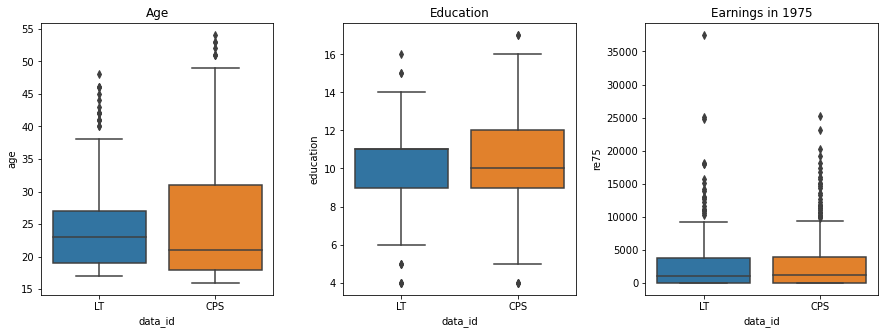

In [31]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

PSID

In [32]:
phat_logit_LT_PSID = fn_propensity_score(treat_id = 'LT', control_id = 'PSID', df = df, method = 'logit')

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_logit_LT_PSID, n_neighbors = 1)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,LT,PSID
treat,1.000000,0.000000
age,24.513605,24.312925
education,10.394558,10.435374
black,0.802721,0.826531
hispanic,0.095238,0.105442
married,0.163265,0.156463
nodegree,0.727891,0.690476
re75,2859.766375,3233.145989
re78,5958.267558,7001.418233
dif,3098.501184,3768.272243


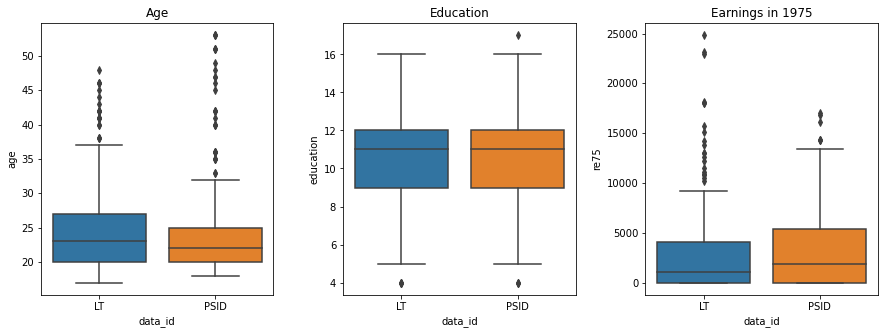

In [33]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

How about DW dataset?

In [34]:
phat_logit_DWT_CPS = fn_propensity_score(treat_id = 'DWT', control_id = 'CPS', df = df, method = 'logit')

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_logit_DWT_CPS, n_neighbors = 1)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,CPS,DWT
treat,0.000000,1.000000
age,24.493976,25.620482
education,10.500000,10.216867
black,0.927711,0.915663
hispanic,0.036145,0.048193
married,0.156627,0.156627
nodegree,0.680723,0.746988
re75,945.376631,1053.871833
re78,5246.258639,6004.840528
re74,1668.480926,1676.139672


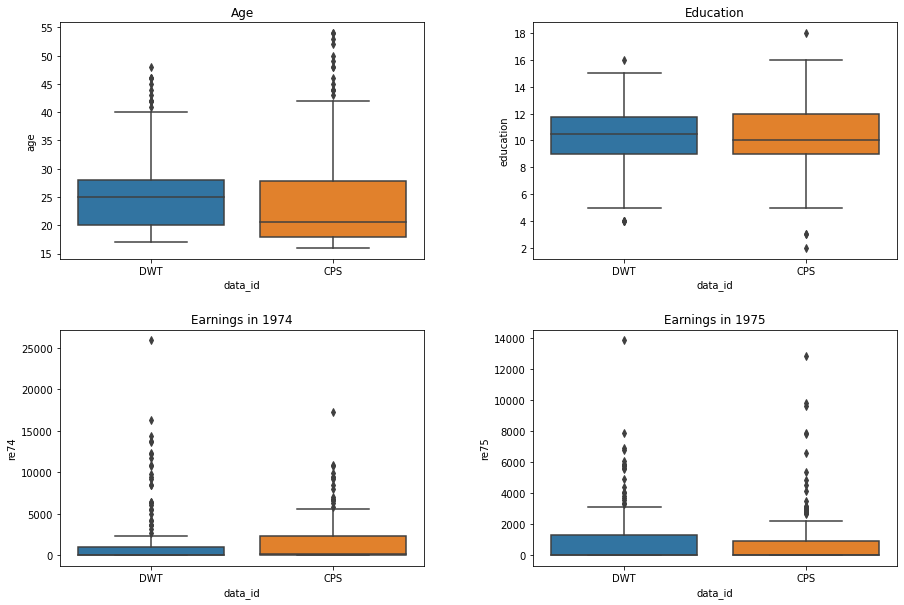

In [35]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [36]:
phat_logit_DWT_PSID = fn_propensity_score(treat_id = 'DWT', control_id = 'PSID', df = df, method = 'logit')

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_logit_DWT_PSID, n_neighbors = 1)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,DWT,PSID
treat,1.000000,0.000000
age,25.638889,25.033333
education,10.333333,10.455556
black,0.838889,0.888889
hispanic,0.061111,0.038889
married,0.166667,0.127778
nodegree,0.711111,0.727778
re75,1133.351571,1735.041407
re78,6117.885886,5943.539499
re74,1613.143910,3981.415164


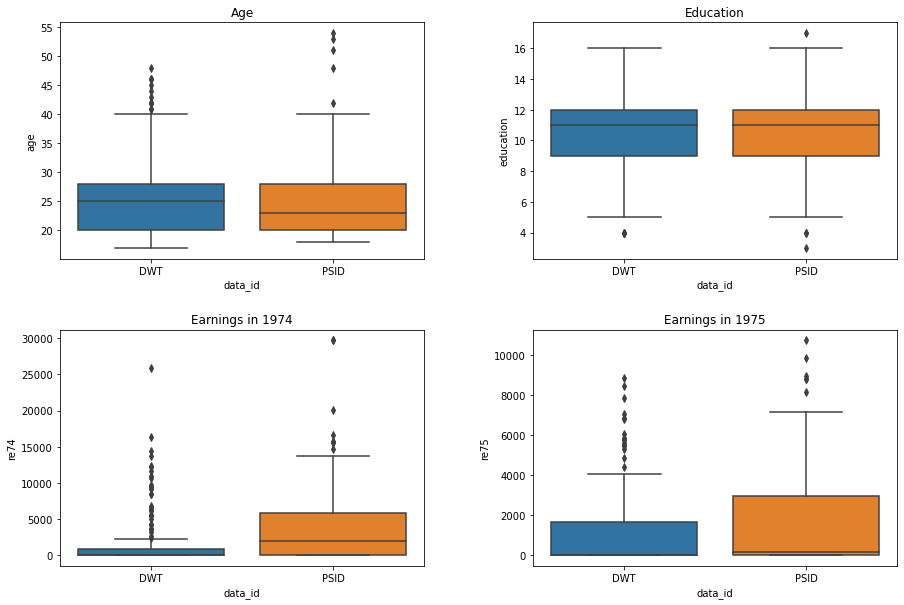

In [37]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

Better than LaLonde?

#### 3.2.2 Estimate propensity score by Random Forest

LaLonde dataset

In [38]:
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

phat_RF_LT_CPS = fn_propensity_score(treat_id = 'LT', control_id = 'CPS', df = df, method = 'RF',
                                     param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_RF_LT_CPS, n_neighbors = 5)
df_matched.head(10)

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,dif,propensity_score,propensity_score_logit,matched_index_1,matched_index_2,matched_index_3,matched_index_4,matched_index_5,matched_outcome_1,matched_outcome_2,matched_outcome_3,matched_outcome_4,matched_outcome_5,distance_1,distance_2,distance_3,distance_4,distance_5,matched_outcome_average
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,9930.045898,0.659518,0.661146,741.0,827.0,1083.0,851.0,813.0,0.000000,1053.619019,0.000000,0.000000,0.000000,0.011800,0.011800,0.492085,0.530805,0.608869,210.723804
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,3595.894043,0.731000,0.999702,741.0,827.0,1083.0,851.0,813.0,0.000000,1053.619019,0.000000,0.000000,0.000000,0.326756,0.326756,0.830640,0.869361,0.947424,210.723804
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,24909.449219,0.322532,-0.742159,382.0,1108.0,307.0,875.0,872.0,1898.879028,1161.493042,15315.412720,0.000000,1642.463867,0.000000,0.000000,0.024915,0.030056,0.039325,4003.649731
3,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,289.789886,0.793000,1.343104,741.0,827.0,1083.0,851.0,813.0,0.000000,1053.619019,0.000000,0.000000,0.000000,0.670158,0.670158,1.174043,1.212763,1.290827,210.723804
4,LT,1.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,4056.493896,4056.493896,0.884267,2.033470,741.0,827.0,1083.0,851.0,813.0,0.000000,1053.619019,0.000000,0.000000,0.000000,1.360524,1.360524,1.864408,1.903129,1.981192,210.723804
5,LT,1.0,23.0,12.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.337006,-0.676665,566.0,340.0,391.0,762.0,352.0,7062.055176,12538.509766,0.000000,91.619049,7362.716492,0.000000,0.000000,0.000000,0.000000,0.034025,5410.980096
6,LT,1.0,32.0,11.0,1.0,0.0,0.0,1.0,0.0,8472.158203,8472.158203,0.856355,1.785338,741.0,827.0,1083.0,851.0,813.0,0.000000,1053.619019,0.000000,0.000000,0.000000,1.112392,1.112392,1.616276,1.654997,1.733060,210.723804
7,LT,1.0,22.0,16.0,1.0,0.0,0.0,0.0,0.0,2164.021973,2164.021973,0.436370,-0.255907,583.0,1054.0,748.0,593.0,717.0,116.740402,0.000000,8355.066406,17941.080078,1260.500977,0.000000,0.034094,0.043483,0.050039,0.068910,5534.677573
8,LT,1.0,33.0,12.0,0.0,0.0,1.0,0.0,0.0,12418.070312,12418.070312,0.064601,-2.672738,497.0,744.0,986.0,862.0,982.0,7138.896973,0.000000,0.000000,9297.856445,25564.669922,0.000000,0.000000,0.000000,0.000000,0.000000,8400.284668
9,LT,1.0,19.0,9.0,1.0,0.0,0.0,1.0,0.0,8173.908203,8173.908203,0.532539,0.130341,851.0,1083.0,813.0,969.0,426.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038720,0.078064,0.078064,0.094136,0.000000


In [39]:
# Conditional mean
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,CPS,LT
treat,0.000000,1.000000
age,17.682594,24.597270
education,10.116041,10.372014
black,0.979522,0.798635
hispanic,0.000000,0.095563
married,0.013652,0.170648
nodegree,0.955631,0.726962
re75,0.000000,3107.956187
re78,591.574811,5971.638722
dif,591.574811,2863.682536


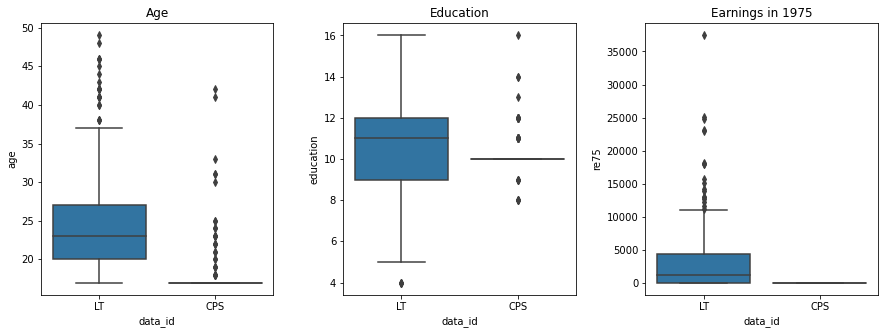

In [40]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

In [41]:
phat_RF_LT_PSID = fn_propensity_score(treat_id = 'LT', control_id = 'PSID', df = df, method = 'RF',
                                      param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_RF_LT_PSID, n_neighbors = 1)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,LT,PSID
treat,1.000000,0.000000
age,25.540323,24.620968
education,10.443548,11.866935
black,0.770161,0.991935
hispanic,0.104839,0.000000
married,0.201613,0.016129
nodegree,0.701613,0.137097
re75,3567.063181,0.000000
re78,6185.323293,1553.221728
dif,2618.260112,1553.221728


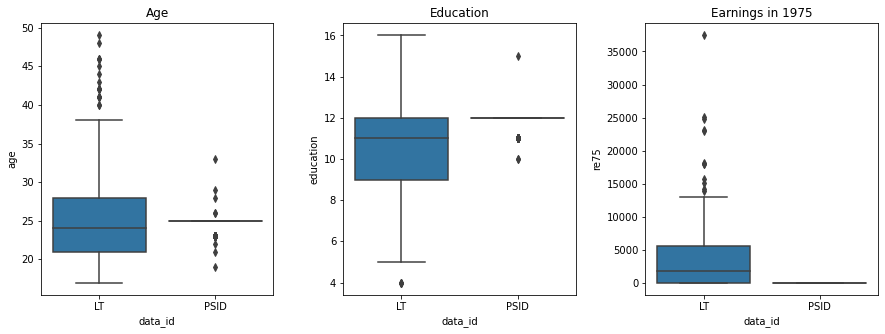

In [42]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

Surprisingly, Random Forest fails to make treatment and control groups comparable.

DW dataset

In [43]:
phat_RF_DWT_CPS = fn_propensity_score(treat_id = 'DWT', control_id = 'CPS', df = df, method = 'RF',
                                      param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_RF_DWT_CPS, n_neighbors = 1)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,CPS,DWT
treat,0.000000,1.000000
age,18.077778,25.800000
education,10.183333,10.344444
black,0.966667,0.838889
hispanic,0.000000,0.061111
married,0.022222,0.194444
nodegree,0.927778,0.700000
re75,0.000000,1574.612405
re78,660.157961,6385.028570
re74,242.350444,2153.784074


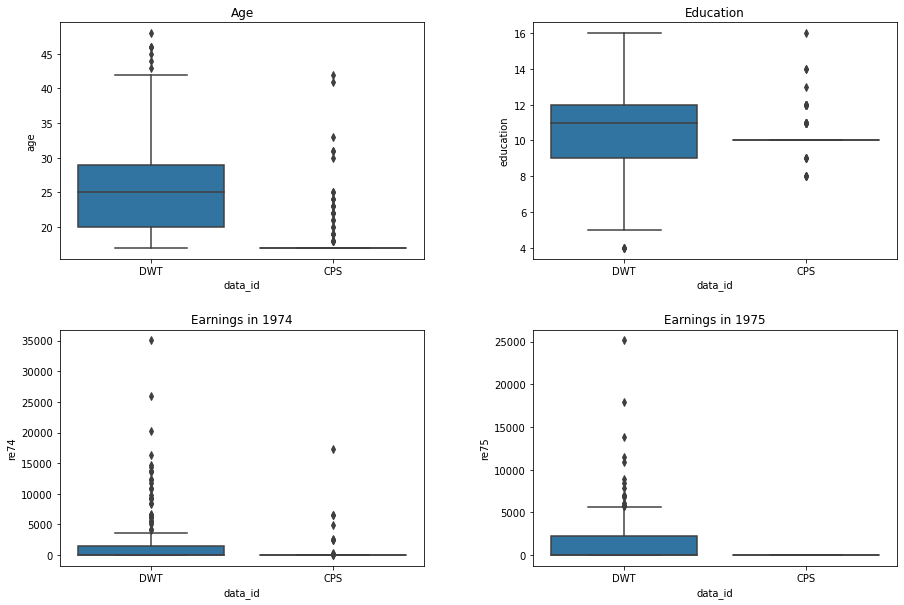

In [44]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [45]:
phat_RF_DWT_PSID = fn_propensity_score(treat_id = 'DWT', control_id = 'PSID', df = df, method = 'RF',
                                       param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_RF_DWT_PSID, n_neighbors = 1)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,DWT,PSID
treat,1.000000,0.000000
age,26.518750,24.731250
education,10.425000,11.856250
black,0.818750,0.987500
hispanic,0.068750,0.000000
married,0.218750,0.050000
nodegree,0.681250,0.156250
re75,1758.611788,0.000000
re78,6572.050071,2327.142287
re74,2412.278901,170.211301


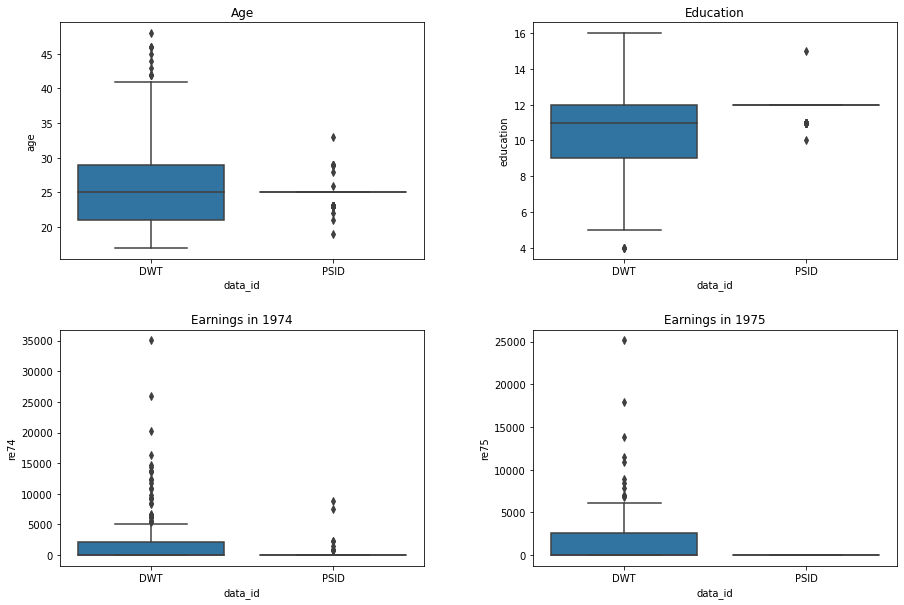

In [46]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

Basically the same with LaLonde dataset.

#### 3.2.3 Estimate propensity score by Gradient Boosting

In [47]:
param_grid = {'n_estimators': [50, 100, 500, 1000],
              'max_features': [2, 3, 4, 5]}

phat_GB_LT_CPS = fn_propensity_score(treat_id = 'LT', control_id = 'CPS', df = df, method = 'GB',
                                     param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_GB_LT_CPS, n_neighbors = 5)
df_matched.head(10)

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,dif,propensity_score,propensity_score_logit,matched_index_1,matched_index_2,matched_index_3,matched_index_4,matched_index_5,matched_outcome_1,matched_outcome_2,matched_outcome_3,matched_outcome_4,matched_outcome_5,distance_1,distance_2,distance_3,distance_4,distance_5,matched_outcome_average
0,LT,1.0,37.0,11.0,1.0,0.0,1.0,1.0,0.0,9930.045898,9930.045898,0.214862,-1.295865,449.0,641.0,969.0,1045.0,917.0,0.000000,0.000000,22650.589844,13397.639648,-2907.966797,0.000000,0.006479,0.006479,0.013175,0.020663,6628.052539
1,LT,1.0,22.0,9.0,0.0,1.0,0.0,1.0,0.0,3595.894043,3595.894043,0.361061,-0.570764,1517.0,1532.0,1704.0,425.0,920.0,1642.463867,10180.005371,-2653.513958,-350.903198,2800.348328,0.008478,0.014196,0.031354,0.032578,0.032578,2323.680082
2,LT,1.0,30.0,12.0,1.0,0.0,0.0,0.0,0.0,24909.449219,24909.449219,0.445279,-0.219763,304.0,1991.0,488.0,491.0,1601.0,731.474670,1161.493042,1898.879028,24360.320312,7044.323242,0.000000,0.000000,0.000000,0.000000,0.000000,7039.298059
3,LT,1.0,27.0,11.0,1.0,0.0,0.0,1.0,0.0,7506.145996,7506.145996,0.859753,1.813239,1929.0,1939.0,885.0,1157.0,1565.0,7543.793945,0.000000,0.000000,3437.191895,0.000000,0.063960,0.387967,0.460416,0.460416,0.509909,2196.197168
4,LT,1.0,33.0,8.0,1.0,0.0,0.0,1.0,0.0,289.789886,289.789886,0.625414,0.512593,1630.0,1992.0,1809.0,950.0,632.0,0.000000,11865.317505,-234.787720,13883.240234,-707.177429,0.000933,0.127820,0.127820,0.173201,0.174274,4961.318518
5,LT,1.0,22.0,9.0,1.0,0.0,0.0,1.0,0.0,4056.493896,4056.493896,0.777003,1.248284,1565.0,1788.0,314.0,885.0,1157.0,0.000000,12959.660156,15315.412720,0.000000,3437.191895,0.055046,0.057239,0.084001,0.104539,0.104539,6342.452954
6,LT,1.0,23.0,12.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.517064,0.068282,887.0,403.0,501.0,1283.0,1003.0,7062.055176,12538.509766,0.000000,91.619049,-205.887100,0.000000,0.000000,0.000000,0.000000,0.017009,3897.259378
7,LT,1.0,32.0,11.0,1.0,0.0,0.0,1.0,0.0,8472.158203,8472.158203,0.640489,0.577486,1809.0,1992.0,1630.0,1769.0,950.0,-234.787720,11865.317505,0.000000,8605.456543,13883.240234,0.062927,0.062927,0.063960,0.157137,0.238094,6823.845312
8,LT,1.0,22.0,16.0,1.0,0.0,0.0,0.0,0.0,2164.021973,2164.021973,0.160156,-1.657068,924.0,2010.0,1728.0,296.0,2011.0,116.740402,-7642.005737,20121.663818,9820.798096,0.000000,0.000000,0.011127,0.011667,0.015658,0.024188,4483.439316
9,LT,1.0,19.0,9.0,1.0,0.0,0.0,1.0,0.0,8173.908203,8173.908203,0.570136,0.282405,1475.0,1801.0,1362.0,1234.0,1893.0,0.000000,6929.913086,335.158936,2015.278076,3081.060059,0.000000,0.005694,0.014404,0.043257,0.055046,2472.282031


In [48]:
# Conditional mean
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,CPS,LT
treat,0.000000,1.000000
age,24.308511,24.411348
education,10.312057,10.301418
black,0.868794,0.836879
hispanic,0.081560,0.099291
married,0.124113,0.156028
nodegree,0.801418,0.762411
re75,2271.322674,2942.312530
re78,5147.943481,5921.940429
dif,2876.620807,2979.627899


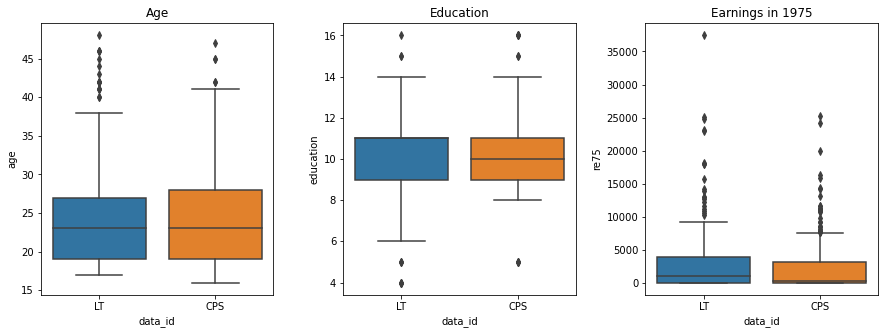

In [49]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

In [50]:
phat_GB_LT_PSID = fn_propensity_score(treat_id = 'LT', control_id = 'PSID', df = df, method = 'GB',
                                      param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_GB_LT_PSID, n_neighbors = 1)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id,LT,PSID
treat,1.000000,0.000000
age,24.626263,23.858586
education,10.380471,10.710438
black,0.801347,0.905724
hispanic,0.094276,0.026936
married,0.168350,0.141414
nodegree,0.730640,0.710438
re75,3066.098191,2472.905668
re78,5976.352024,9357.775677
dif,2910.253832,6884.870009


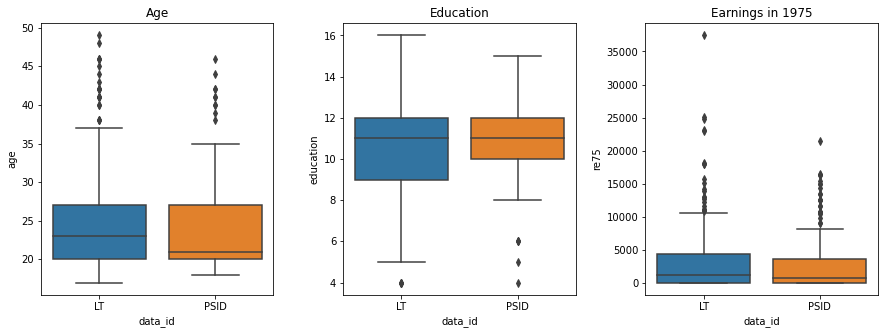

In [51]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

In [52]:
phat_GB_DWT_CPS = fn_propensity_score(treat_id = 'DWT', control_id = 'CPS', df = df, method = 'GB',
                                      param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_GB_DWT_CPS, n_neighbors = 1)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,CPS,DWT
treat,0.000000,1.000000
age,25.845714,25.857143
education,10.748571,10.251429
black,0.897143,0.880000
hispanic,0.034286,0.057143
married,0.177143,0.171429
nodegree,0.720000,0.737143
re75,895.631887,1345.134001
re78,3815.591214,6021.122828
re74,2782.573035,1762.161255


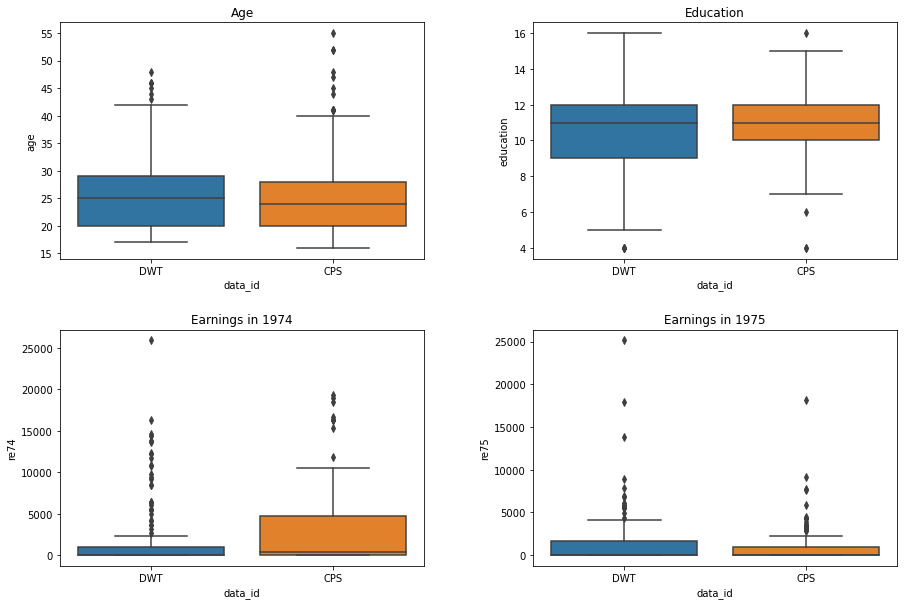

In [53]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [54]:
phat_GB_DWT_PSID = fn_propensity_score(treat_id = 'DWT', control_id = 'PSID', df = df, method = 'GB',
                                       param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_GB_DWT_PSID, n_neighbors = 1)

df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id,DWT,PSID
treat,1.000000,0.000000
age,25.816216,25.454054
education,10.345946,10.572973
black,0.843243,0.924324
hispanic,0.059459,0.010811
married,0.189189,0.194595
nodegree,0.708108,0.767568
re75,1532.055313,1377.716140
re78,6349.143502,3914.833165
re74,2095.573693,2641.451702


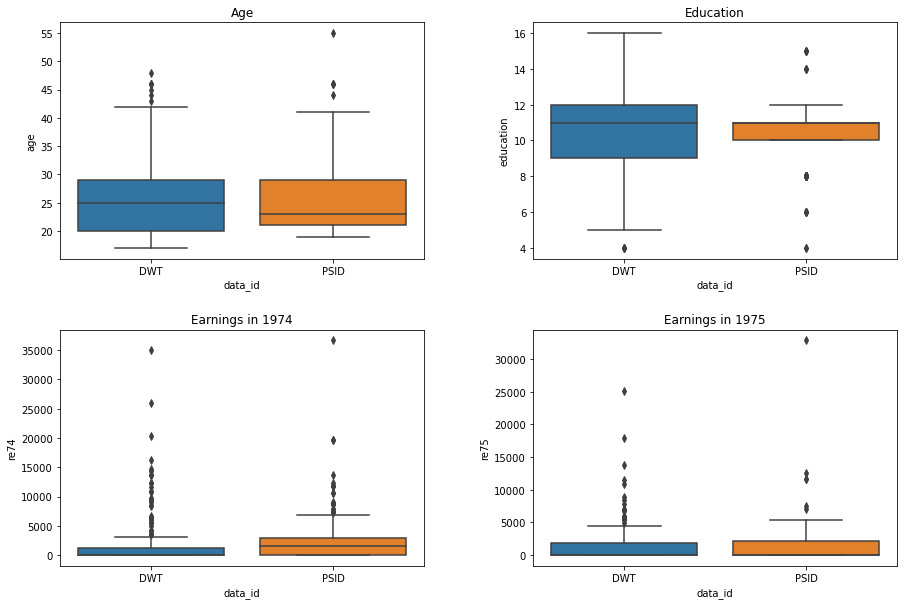

In [55]:
# Boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

#### 3.2.4 ATE and ATET estimates

In [56]:
param_grid_p = {'n_estimators': [50, 100, 500, 1000],
                'max_features': [2, 3, 4, 5]}
param_grid_mu = {'n_estimators': [50, 100, 500, 1000],
                 'max_features': [2, 3, 4, 5]}

df_results = fn_generate_df_results(df = df, param_grid_p = param_grid_p, param_grid_mu = param_grid_mu)

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [2:32:57<00:00, 4588.55s/it]


In [57]:
# Output the results as .csv file
df_results.to_csv('./results/others.csv', index = False)

In [58]:
PSM_summary = fn_pick_results(df_results, method = 'PSM')
PSM_summary[PSM_summary.Outcome == 'dif'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Neighbors,Caliper_Std,ATE,ATET
0,dif,LT,CPS,PSM,logit,1.0,0.1,-2122.159242,-142.154448
1,dif,LT,CPS,PSM,logit,1.0,0.2,-2122.159242,-142.154448
2,dif,LT,CPS,PSM,logit,1.0,1.0,-2122.159242,-142.154448
3,dif,LT,CPS,PSM,logit,10.0,0.1,-2096.141401,-445.395890
4,dif,LT,CPS,PSM,logit,10.0,0.2,-2354.402094,-445.395890
5,dif,LT,CPS,PSM,logit,10.0,1.0,-2424.962276,-445.395890
6,dif,LT,CPS,PSM,RF,1.0,0.1,3934.530419,491.890046
7,dif,LT,CPS,PSM,RF,1.0,0.2,4557.077605,1208.736845
8,dif,LT,CPS,PSM,RF,1.0,1.0,6622.149390,2155.340080
9,dif,LT,CPS,PSM,RF,10.0,0.1,3742.010294,247.724055


In [59]:
PSM_summary[PSM_summary.Outcome == 're78'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Neighbors,Caliper_Std,ATE,ATET
0,re78,LT,CPS,PSM,logit,1.0,0.1,-889.828448,-366.189363
1,re78,LT,CPS,PSM,logit,1.0,0.2,-889.828448,-366.189363
2,re78,LT,CPS,PSM,logit,1.0,1.0,-889.828448,-366.189363
3,re78,LT,CPS,PSM,logit,10.0,0.1,-841.607548,-572.825213
4,re78,LT,CPS,PSM,logit,10.0,0.2,-1002.031836,-572.825213
5,re78,LT,CPS,PSM,logit,10.0,1.0,-1107.750629,-572.825213
6,re78,LT,CPS,PSM,RF,1.0,0.1,3027.456783,4854.238778
7,re78,LT,CPS,PSM,RF,1.0,0.2,3090.407526,5343.880170
8,re78,LT,CPS,PSM,RF,1.0,1.0,3402.142044,5571.871074
9,re78,LT,CPS,PSM,RF,10.0,0.1,2835.841446,4538.252942


### 3.3 Inverse Probability of Treatment Weighted (IPTW) Estimator

The IPTW estimator weights outcome values based on the propensity score estimate. The estimator uses $1/\hat{p}(X_i)$ as weights for treated samples and $1/(1 - \hat{p}(X_i))$ for controlled samples. That way, we can estimate the ATE by

$$
\hat{\tau}_{ATE} = \frac{1}{n} \sum_{i = 1}^n \frac{D_i Y_i}{\hat{p}(X_i)} - \frac{1}{n} \sum_{i = 1}^n \frac{(1 - D_i) Y_i}{1 - \hat{p}(X_i)}.
$$

We apply the IPTW estimator using the same propensity score estimates as we have used for matching. That is, we estimate $p(X_i)$ by logistic regression, Random Forest and Gradient Boosting.

#### 3.3.1 Estimate propensity score by logistic regression

In [60]:
IPTW_summary = fn_pick_results(df_results, method = 'IPTW')
IPTW_summary[IPTW_summary.Est_Prop == 'logit'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE
0,dif,LT,CPS,IPTW,logit,-2779.761998
1,dif,LT,PSID,IPTW,logit,-5954.985771
2,dif,DWT,CPS,IPTW,logit,-192.714901
3,dif,DWT,PSID,IPTW,logit,-1076.628815
4,re78,LT,CPS,IPTW,logit,-1634.390493
5,re78,LT,PSID,IPTW,logit,-2196.506472
6,re78,DWT,CPS,IPTW,logit,-1008.058240
7,re78,DWT,PSID,IPTW,logit,-2806.561656


#### 3.3.2 Estimate propensity score by Random Forest

In [61]:
IPTW_summary[IPTW_summary.Est_Prop == 'RF'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE
0,dif,LT,CPS,IPTW,RF,-1068.692040
1,dif,LT,PSID,IPTW,RF,-1963.545555
2,dif,DWT,CPS,IPTW,RF,-646.209340
3,dif,DWT,PSID,IPTW,RF,-1108.199315
4,re78,LT,CPS,IPTW,RF,-4079.636949
5,re78,LT,PSID,IPTW,RF,-5601.428196
6,re78,DWT,CPS,IPTW,RF,-2932.768942
7,re78,DWT,PSID,IPTW,RF,-4698.777355


#### 3.3.3 Estimate propensity score by Gradient Boosting

In [62]:
IPTW_summary[IPTW_summary.Est_Prop == 'GB'].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,ATE
0,dif,LT,CPS,IPTW,GB,-1844.072253
1,dif,LT,PSID,IPTW,GB,-2951.308867
2,dif,DWT,CPS,IPTW,GB,1011.929115
3,dif,DWT,PSID,IPTW,GB,-3742.619171
4,re78,LT,CPS,IPTW,GB,-1835.061750
5,re78,LT,PSID,IPTW,GB,-7703.527557
6,re78,DWT,CPS,IPTW,GB,1116.794245
7,re78,DWT,PSID,IPTW,GB,-4402.457967


### 3.4 Doubly Robust Estimator

The doubly robust estimator combines propensity score weighting and imputation regression methods. Specifically, the ATE estimate is given by

$$
\hat{\tau}_{ATE} = \frac{1}{n} \sum_{i = 1}^n \left( \frac{D_i(Y_i - \hat{\mu}_1 (X_i))}{\hat{p}(X_i)} + \hat{\mu}_1 (X_i) \right) - \frac{1}{n} \sum_{i = 1}^n \left( \frac{(1 - D_i)(Y_i - \hat{\mu}_0 (X_i))}{1 - \hat{p}(X_i)} + \hat{\mu}_0 (X_i) \right).
$$

The estimator is known to be "doubly robust" in the sense that it is consistent if either $\hat{p}(X_i)$ or $\hat{\mu}_d (X_i), d \in \{0,1 \}$ is consistent. Thus, we expect that the doubly robust estimator can take advantages of both regression and propensity score methods and improve our ATE estimates.  

We use the same propensity score estimates as in 3.2 and 3.3 here as well. For estimation of $\hat{\mu}_d (X_i), d \in \{0,1 \}$, we rely on machine learning methods: Random Forest and Gradient Boosting.

#### 3.4.1 Estimate $\mu_1(X)$ and $\mu_0(X)$ by Random Forest

In [63]:
DR_summary = fn_pick_results(df_results, method = 'DR')
DR_summary[(DR_summary.Outcome == 'dif') & (DR_summary.Est_Imput == 'RF')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,dif,LT,CPS,DR,logit,RF,-1070.433063
1,dif,LT,CPS,DR,RF,RF,-240.758615
2,dif,LT,CPS,DR,GB,RF,-1087.297562
3,dif,LT,PSID,DR,logit,RF,-2953.665962
4,dif,LT,PSID,DR,RF,RF,-2867.680171
5,dif,LT,PSID,DR,GB,RF,-2487.258289
6,dif,DWT,CPS,DR,logit,RF,838.943153
7,dif,DWT,CPS,DR,RF,RF,1433.463689
8,dif,DWT,CPS,DR,GB,RF,702.344958
9,dif,DWT,PSID,DR,logit,RF,-596.467871


In [64]:
DR_summary[(DR_summary.Outcome == 're78') & (DR_summary.Est_Imput == 'RF')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,re78,LT,CPS,DR,logit,RF,-767.654061
1,re78,LT,CPS,DR,RF,RF,-223.528600
2,re78,LT,CPS,DR,GB,RF,-1184.582342
3,re78,LT,PSID,DR,logit,RF,-2726.637828
4,re78,LT,PSID,DR,RF,RF,-3300.768582
5,re78,LT,PSID,DR,GB,RF,-4002.878682
6,re78,DWT,CPS,DR,logit,RF,819.858610
7,re78,DWT,CPS,DR,RF,RF,1300.887128
8,re78,DWT,CPS,DR,GB,RF,740.090316
9,re78,DWT,PSID,DR,logit,RF,-604.377765


#### 3.4.2 Estimate $\mu_1(X)$ and $\mu_0(X)$ by Gradient Boosting

In [65]:
DR_summary[(DR_summary.Outcome == 'dif') & (DR_summary.Est_Imput == 'GB')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,dif,LT,CPS,DR,logit,GB,-979.868725
1,dif,LT,CPS,DR,RF,GB,-609.607699
2,dif,LT,CPS,DR,GB,GB,-1859.321356
3,dif,LT,PSID,DR,logit,GB,-4314.864642
4,dif,LT,PSID,DR,RF,GB,-2079.015533
5,dif,LT,PSID,DR,GB,GB,-2598.796529
6,dif,DWT,CPS,DR,logit,GB,1026.279889
7,dif,DWT,CPS,DR,RF,GB,1013.436880
8,dif,DWT,CPS,DR,GB,GB,1045.648788
9,dif,DWT,PSID,DR,logit,GB,-57.601351


In [66]:
DR_summary[(DR_summary.Outcome == 're78') & (DR_summary.Est_Imput == 'GB')].reset_index(drop = True)

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,re78,LT,CPS,DR,logit,GB,-959.828405
1,re78,LT,CPS,DR,RF,GB,-582.649064
2,re78,LT,CPS,DR,GB,GB,-1859.584932
3,re78,LT,PSID,DR,logit,GB,-3422.914840
4,re78,LT,PSID,DR,RF,GB,-3058.262494
5,re78,LT,PSID,DR,GB,GB,-3979.612957
6,re78,DWT,CPS,DR,logit,GB,486.847900
7,re78,DWT,CPS,DR,RF,GB,1134.896122
8,re78,DWT,CPS,DR,GB,GB,308.532871
9,re78,DWT,PSID,DR,logit,GB,-515.481421


## 4. Findings

a. What are your main findings?  
b. Are your findings robust to different model specifications?

The first table shows the results of treatment effect estimated by linear regression model. The experimental treatment effects ranges from 798 to 886 for Lalonde data, and ranges from 1375 to 1794 for Dehejia and Wahba data, considering different specifications and outcome variable. 

Overall, the regression results of the non-experiment data fail to generate similar results of experiment results neither for Lalonde's data nor for DW's data, where the closest one differs more than 400 from the true. In addition, the non-experiment treatment effects are very sensitive to the outcome variable, they are mostly positive when outcome variable is 're78 - re75' but mostly negative when it is 're78'. In addition, they are also sensitive to the covariates that we control. The ranges are more than 1000 when outcome variable is 're78 - re75' and are more than 4000 when it is 're78'.


In [67]:
reg_summary_dif

,Outcome,Treatment,Control,Without control,With age,With all controls
0,dif,LT,LC,846.888287,856.910955,800.535314
1,dif,LT,CPS,1714.397705,195.174602,-999.609429
2,dif,LT,PSID,419.670577,-749.207210,-1347.796366
3,dif,DWT,DWC,1529.196083,1516.996931,1636.108327
4,dif,DWT,CPS,3621.232061,2383.311533,622.547024
5,dif,DWT,PSID,2326.504934,1256.927930,455.570948


In [68]:
reg_summary_re78

,Outcome,Treatment,Control,Without control,With age,With all controls
0,re78,LT,LC,886.303722,881.739626,800.535314
1,re78,LT,CPS,-8870.307627,-7172.308044,-999.609429
2,re78,LT,PSID,-15577.568900,-13267.657059,-1347.796366
3,re78,DWT,DWC,1794.342382,1736.057724,1636.108327
4,re78,DWT,CPS,-8497.516148,-7274.306837,622.547024
5,re78,DWT,PSID,-15204.777421,-13268.950367,455.570948


The second and third table shows the results of treatment effect estimated by Random Forest Regression and Gradient Boosting Regression. The main finding is that PSID control group could generate similar treatment effect as the experiment data does for the Lalonde data when the outcome variable is 're78 - re75'. Their difference is only about 70 under both method, while the difference is more than 700 for the DW's data. It somehow provides the support for the conjecture that the linear specification may be wrong when estimating the non-experiment treatment effect.

In [69]:
RF_summary

,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,dif,LT,LC,Regression,RF,913.562291,730.663394
1,dif,LT,CPS,Regression,RF,-3919.466121,-202.885791
2,dif,LT,PSID,Regression,RF,-2514.203037,-1276.980889
3,dif,DWT,DWC,Regression,RF,1395.593161,1386.034357
4,dif,DWT,CPS,Regression,RF,-969.110691,1214.246394
5,dif,DWT,PSID,Regression,RF,147.656866,-303.618709
6,re78,LT,LC,Regression,RF,851.942763,751.353774
7,re78,LT,CPS,Regression,RF,-2642.431374,-315.532116
8,re78,LT,PSID,Regression,RF,-6061.104723,-1613.389493
9,re78,DWT,DWC,Regression,RF,1465.645909,1530.928505


In [70]:
GB_summary

,Outcome,Treatment,Control,Method,Est_Imput,ATE,ATET
0,dif,LT,LC,Regression,GB,715.291790,763.023051
1,dif,LT,CPS,Regression,GB,-4763.138893,-599.751690
2,dif,LT,PSID,Regression,GB,-2416.219321,-1152.807313
3,dif,DWT,DWC,Regression,GB,1394.664391,1423.638152
4,dif,DWT,CPS,Regression,GB,-2380.891771,1037.101413
5,dif,DWT,PSID,Regression,GB,-666.331403,611.295655
6,re78,LT,LC,Regression,GB,751.913736,782.370136
7,re78,LT,CPS,Regression,GB,-3832.432449,-1017.893113
8,re78,LT,PSID,Regression,GB,-5362.091815,-1995.153173
9,re78,DWT,DWC,Regression,GB,1471.936854,1583.223852


The fourth table shows the results of treatment effect estimated by Propensity Score Matching, where it uses logit regression or random forest to estimate the propensity score. For the Lalonde data, the treatment effect remains negative if it uses logit regression to estimate the propensity score. The main finding here is that CPS control group, given the outcome variable 're78 - re75' and random forest method to estimate the propensity score, could generate 794 average treatment effect on the treated, which is very close to the true treatment effect 819 estimated by linear regression and 793 estimated by Gradient Boosting.

On the other hand, for the DW data, the treatment effects are all positive, but are at least 1000 larger than the true effect if it uses random forest to estimate the propensity score. The main finding in DW data here is that if it uses logit regression to estimate the propensity score, CPS control group could generate 1324 average treatment effect when the outcome variable is 're78 - re75' and 1229 average treatment effect when the outcome variable is 're78', they are very close to true treatment effect 1375 estimated by linear regression, 1335 estimated by Random Forest and 1124 estimated by Gradient Boosting.

Overall, when it uses propensity score matching to estimate the non-experimental treatment effect, CPS group could provide similar results as the experimental treatment effect under the condition that estimation method and outcome variable are correctly specified.

In [71]:
PSM_summary

,Outcome,Treatment,Control,Method,Est_Prop,Neighbors,Caliper_Std,ATE,ATET
0,dif,LT,CPS,PSM,logit,1.0,0.1,-2122.159242,-142.154448
1,dif,LT,CPS,PSM,logit,1.0,0.2,-2122.159242,-142.154448
2,dif,LT,CPS,PSM,logit,1.0,1.0,-2122.159242,-142.154448
3,dif,LT,CPS,PSM,logit,10.0,0.1,-2096.141401,-445.395890
4,dif,LT,CPS,PSM,logit,10.0,0.2,-2354.402094,-445.395890
5,dif,LT,CPS,PSM,logit,10.0,1.0,-2424.962276,-445.395890
6,dif,LT,CPS,PSM,RF,1.0,0.1,3934.530419,491.890046
7,dif,LT,CPS,PSM,RF,1.0,0.2,4557.077605,1208.736845
8,dif,LT,CPS,PSM,RF,1.0,1.0,6622.149390,2155.340080
9,dif,LT,CPS,PSM,RF,10.0,0.1,3742.010294,247.724055


The fifth table shows the results of treatment effect estimated by Inverse Probability of Treatment Weighted. All of the average treatment effect estimated by this method remain negative. Therefore, it concludes that this method is not an appropriate one to estimate the non-experiment treatment effect.

In [72]:
IPTW_summary

,Outcome,Treatment,Control,Method,Est_Prop,ATE
0,dif,LT,CPS,IPTW,logit,-2779.761998
1,dif,LT,CPS,IPTW,RF,-1068.692040
2,dif,LT,CPS,IPTW,GB,-1844.072253
3,dif,LT,PSID,IPTW,logit,-5954.985771
4,dif,LT,PSID,IPTW,RF,-1963.545555
5,dif,LT,PSID,IPTW,GB,-2951.308867
6,dif,DWT,CPS,IPTW,logit,-192.714901
7,dif,DWT,CPS,IPTW,RF,-646.209340
8,dif,DWT,CPS,IPTW,GB,1011.929115
9,dif,DWT,PSID,IPTW,logit,-1076.628815


The last table shows the results of treatment effect estimated by Doubly Robust Estimation. It still remain negative for all the average treatment effect in the Lalonde data and for the average treatment effect using PSID control group in the DW data. The main finding here is that CPS control group in the DW data could generate similar result as the true treatment effect, especially when it uses random forest to estimate $\mu$. It generates 1233 when 're78 - re75' works as the outcome variable and 1253 when 're78' does, and they are very close to true treatment effect 1375 estimated by linear regression, 1335 estimated by Random Forest and 1124 estimated by Gradient Boosting.

In [73]:
DR_summary

,Outcome,Treatment,Control,Method,Est_Prop,Est_Imput,ATE
0,dif,LT,CPS,DR,logit,RF,-1070.433063
1,dif,LT,CPS,DR,logit,GB,-979.868725
2,dif,LT,CPS,DR,RF,RF,-240.758615
3,dif,LT,CPS,DR,RF,GB,-609.607699
4,dif,LT,CPS,DR,GB,RF,-1087.297562
5,dif,LT,CPS,DR,GB,GB,-1859.321356
6,dif,LT,PSID,DR,logit,RF,-2953.665962
7,dif,LT,PSID,DR,logit,GB,-4314.864642
8,dif,LT,PSID,DR,RF,RF,-2867.680171
9,dif,LT,PSID,DR,RF,GB,-2079.015533


In conclusion, this paper conducts several estimation methods to investigate the non-experiment treatment effect with the CPS and PSID data. Although it finds that under some conditions that the non-experiment data could generate similar results as the experiment data does, the results are very sensitive to the outcome variable, the estimation method and the control group. Therefore, it should be cautious to reach the conclusion that we can estimate casual effects in NSW using non-experiment data.

In the Propensity Score Matching estimation, it could generate similar results for Lalonde data and DW data that CPS control group could replicate the true treatment, with only the exception that they need to use different method to estimate the propensity score. However, the results differ between Lalonde and DW data in other estimation strategies.
PSID could replicate the results for Lalonde data in the Random Forest Regression and Gradient Boosting Regression, while CPS does for DW data in the Doubly Robust Estimation. 

Overall, this results could somehow provide support for Dehejia and Wahba (1999, 2002) that propensity score matching estimation could alleviate the bias due to systematic differences between the treated and comparison units and replicate the causal effect in NSW with non-experiment dataset.

## 5. Conclusion

a. Discuss what we’ve learned from your analysis.  
b. Discuss any questions that could be answered in the future.

We re-examined whether the causal effect can be estimated of the NSW with nonexperimental data, which is a long-standing debate, by incorporating various machine learning methods, such as Random Forest Regression and Gradient Boosting Regression, into the causal inference and trying various specifications. Our analysis provides new arguments to support the conclusion of DW, while reconcile the possibility that Lalonde and DW have different conclusions due to different datasets.

From the analysis, we mainly leads to two conclusions. First, our study estimating causal effects in NSW using nonexperimental data is not generalizable, and it depends on the outcome variable, estimation method, and control group. Second, the results for Lalonde and DW are different under the same model, and using different methods for estimation may yield similar results.

In future research, firstly, we can try to find a way to enhance the robustness of the results so that the model can be widely applicable to the estimation of the casual effect in a specific context. Furthermore, we can focus on how to choose an appropriate model without experimental data, because in economics research, there is no random experiment in most situations, so how to identify the best specification in this case is the key to the problem.

## Endnotes

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Aid to Families with Dependent Children.

## References

1. Abadie, A., & Cattaneo, M. D. (2008). Econometric methods for program evaluation. *Annual Review of Economics*, 10(1), 465&ndash;503.
2. Dehejia, R., & Wahba, S. (1999). Causal effects in nonexperimental studies: Reevaluating the evaluation of training programs. *Journal of the American Statistical Association*, 94(448), 1053&ndash;1062.  
3. Dehejia, R., & Wahba, S. (2002). Propensity score-matching methods for nonexperimental causal studies. *Review of Economics and Statistics*, 84(1), 151&ndash;161.  
4. LaLonde, R. (1986). Evaluating the econometric evaluations of training programs with experimental data. *American Economic Review*, 76(4), 604&ndash;620.  
5. Müller, A. C., & Guido, S. (2016). *Introduction to machine learning with Python: A guide for data scientists.* O'Reilly Media.
6. Smith, J. A., & Todd, P. E. (2005). Does matching overcome LaLonde’s critique of nonexperimental estimators? *Journal of Econometrics*, 125(1–2), 305&ndash;353.  